# 1. Import Packages and Data

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
from collections import Counter
from wordcloud import WordCloud
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/BT4012/fake_job_postings.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range  \
0  Marketing          NaN   
1    Success          NaN   
2        NaN          NaN   
3      Sales          NaN   
4        NaN          NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           company_profile  \
0                                                                                                                    We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City.   
1  90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal, L’Oreal, Sony and Barclays and has offices in ...   
2                                                                                                                          Valor Services provides Workforce Solutions that meet the needs of companies across the Private Sector, with a special focus on the Oil &amp; Gas Industry. Valor Services will be involved with you throughout every step of the hiri

#2. Dataset Basic Statistics

Dataset Shape

In [120]:
#Shape of Dataframe
rows, columns = df.shape

print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

Number of rows: 17880
Number of columns: 18


Column Types:

In [121]:
#Column Types
column_types = df.dtypes
print('Column Types:')
print(column_types)
print()

Column Types:
job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object



17 Columns in total, 13 String Type Columns, 5 Integer Type Columns

Null Values

In [122]:
#Null values
null_counts = df.isnull().sum()
print('Null Values: ')
print(null_counts)

Null Values: 
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [123]:
unique_counts = df.nunique()
print(unique_counts)

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11967
benefits                6204
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64


Duplicate Rows:

In [124]:
#Number of duplicate rows
num_duplicates = df.drop(columns='job_id').duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}\n")


Number of duplicate rows: 281



Without job_id, 281 duplicate rows. Dropping duplicate rows:

In [125]:
df=df.drop(columns='job_id')
df.drop_duplicates(inplace=True)
df.shape

(17599, 17)

# 3. Exploratory Data Analysis (EDA)

## Fraud vs NonFraud Analysis

In [126]:
total_counts = len(df)

non_fraud_counts = (df['fraudulent'] == 0).sum()
fraud_counts = (df['fraudulent'] == 1).sum()

#Percentage
non_fraud_per = (non_fraud_counts / total_counts) * 100
fraud_per = (fraud_counts / total_counts) * 100

print(f'Percentage of Fraud Counts in Dataset: {fraud_per:.2f}%')
print(f'Percentage of Non-Fraud Counts in Dataset: {non_fraud_per:.2f}%')

Percentage of Fraud Counts in Dataset: 4.86%
Percentage of Non-Fraud Counts in Dataset: 95.14%


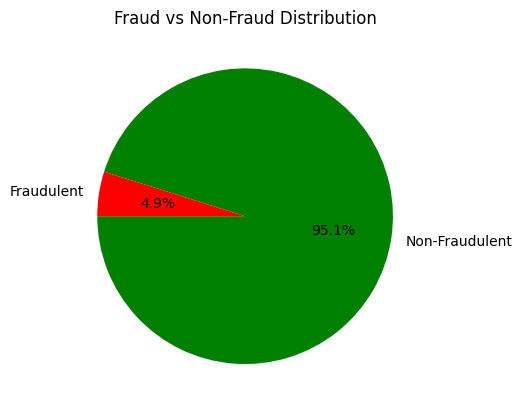

In [127]:
# Data for plotting
categories = ['Non-Fraudulent', 'Fraudulent']
values = [non_fraud_counts, fraud_counts]

# Create pie chart
plt.pie(values, labels=categories, colors=['green', 'red'], autopct='%1.1f%%', startangle=180)
plt.title('Fraud vs Non-Fraud Distribution')

# Show plot
plt.show()

Dataset classification highly uneven, required to equalise the proportion later on.

## Investigating Insights in Fraud Related Cases

Prepare dataset with only Fraudulent Cases

In [128]:
fraud_data = df[df['fraudulent'] == 1]
non_fraud_data = df[df['fraudulent'] == 0]

### Function Column Analysis

In [129]:
print(f"Fraudulent proportion of Null Values for Function : {fraud_data['function'].isnull().sum()/len(fraud_data)}")
print(f"Non-Fraudulent proportion of Null Values for Function: {non_fraud_data['function'].isnull().sum()/len(non_fraud_data)}")

Fraudulent proportion of Null Values for Function : 0.3855140186915888
Non-Fraudulent proportion of Null Values for Function: 0.3603296900197097


In [130]:
non_fraud_data['function'].isnull().sum()/len(non_fraud_data)

0.3603296900197097

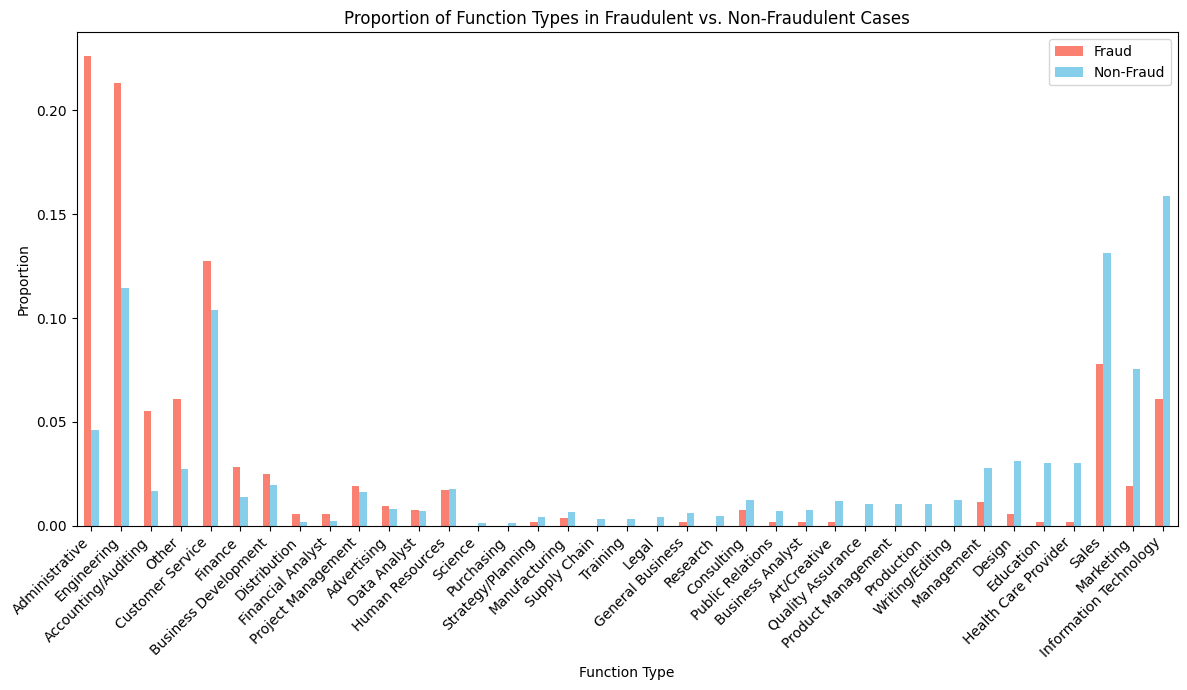

In [131]:
#Proportion of each function for Fraud vs Non-Fraud
fraud_function_counts = fraud_data['function'].value_counts(normalize=True)
non_fraud_function_counts = non_fraud_data['function'].value_counts(normalize=True)

function_proportions = pd.DataFrame({
    'Fraud': fraud_function_counts,
    'Non-Fraud': non_fraud_function_counts
}).fillna(0)

#Sort by difference in fraud vs nonfraud
function_proportions['Difference'] = function_proportions['Fraud'] - function_proportions['Non-Fraud']

function_proportions_sorted = function_proportions.sort_values(by='Difference', ascending=False)

function_proportions_sorted[['Fraud', 'Non-Fraud']].plot(kind='bar', figsize=(12, 7), color=['salmon','skyblue'])
plt.xlabel('Function Type')
plt.ylabel('Proportion')
plt.title('Proportion of Function Types in Fraudulent vs. Non-Fraudulent Cases')
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


Certain Functions like Administrative, Accounting/Auditing, Engineering etc have higher propensity for fraud.

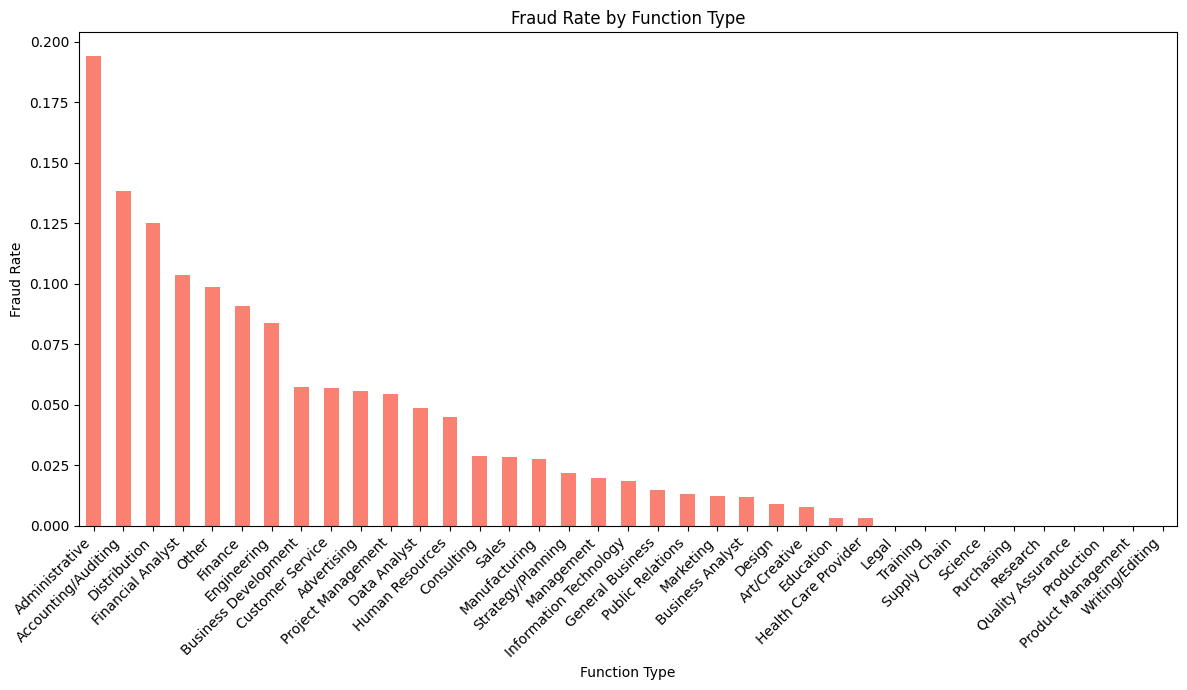

In [132]:
# Calculate counts for each function type in fraud and non-fraud data
fraud_function_counts = fraud_data['function'].value_counts()
non_fraud_function_counts = non_fraud_data['function'].value_counts()

# Combine fraud and non-fraud counts into a DataFrame
function_counts = pd.DataFrame({
    'Fraud': fraud_function_counts,
    'Non-Fraud': non_fraud_function_counts
}).fillna(0)

# Calculate total counts (Fraud + Non-Fraud)
function_counts['Total'] = function_counts['Fraud'] + function_counts['Non-Fraud']

# Calculate fraud rate for each function (Fraud / Total)
function_counts['Fraud Rate'] = function_counts['Fraud'] / function_counts['Total']

# Sort by Fraud Rate in descending order
function_counts_sorted = function_counts.sort_values(by='Fraud Rate', ascending=False)

# Plot Fraud Rate
function_counts_sorted['Fraud Rate'].plot(kind='bar', figsize=(12, 7), color='salmon')
plt.xlabel('Function Type')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Function Type')
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

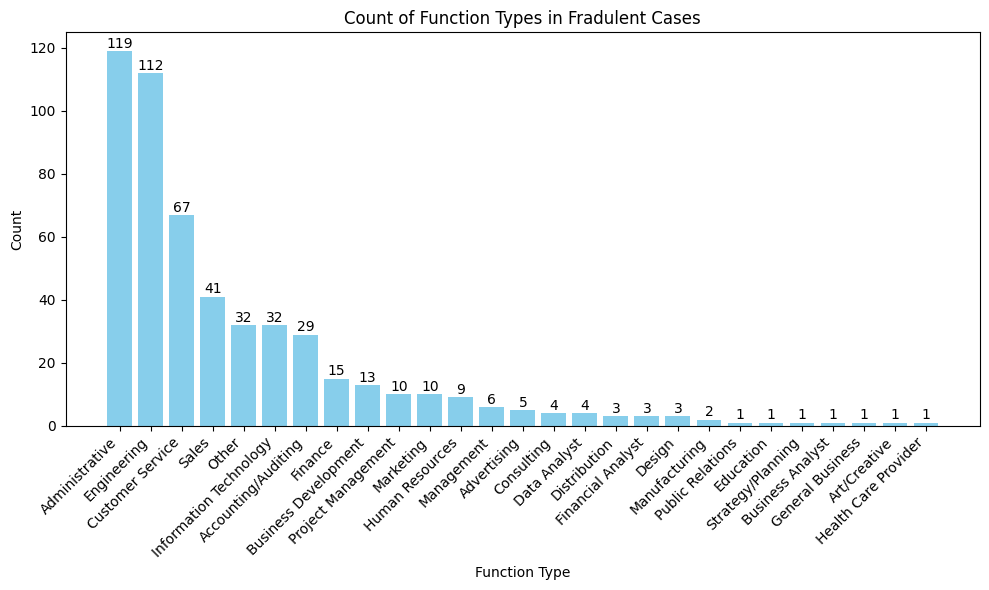

In [133]:
# Count the occurrences of each function type
function_counts = fraud_data['function'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(function_counts.index, function_counts.values, color='skyblue')
plt.xlabel('Function Type')
plt.ylabel('Count')
plt.title('Count of Function Types in Fradulent Cases')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

Based on fraud rate and counts, we can see that some function types such as 'Admistrative' and 'Engineering' have both high numbers and fraud rates, so these functions are at a higher propensity for fraud. No conclusions can be made for other function types since their numbers are too small.

### Location Analysis

Given the number of unique states, we will group the location by country.

In [134]:
fraud_data['country'] = fraud_data['location'].str[:2]
non_fraud_data['country'] = non_fraud_data['location'].str[:2]
fraud_data.head()

<ipython-input-134-3164fc252d83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_data['country'] = fraud_data['location'].str[:2]
<ipython-input-134-3164fc252d83>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_fraud_data['country'] = non_fraud_data['location'].str[:2]


title                            location  \
98                     IC&E Technician                   US, , Stocton, CA   
144                       Forward Cap.                                 NaN   
173  Technician Instrument & Controls                                   US   
180                    Sales Executive                     PK, SD, Karachi   
215            IC&E Technician Mt Poso  US, CA, Bakersfield, CA / Mt. Poso   

               department  salary_range  \
98           Oil & Energy  95000-115000   
144                   NaN           NaN   
173  Power Plant & Energy           NaN   
180                 Sales           NaN   
215          Oil & Energy  95000-115000   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             company_profile  \
98                                                                                    Staffing &amp; Recruiting done right for the Oil &amp; Energy Industry!Represented candidates are automatically granted the following perks: Expert negotiations on your behalf, maximizing your compensation package and implimenting ongoing increases Significant signing bonus by Refined Resources (in addition to any potential signing bonuses our client companies offer)1 Year access to AnyPerk: significant corporate discounts on cell phones, event tickets, house cleaning and everything inbetween.  You'll save thousands on daily expenditures Professional Relocation Services for out of town candidates* All candidates are encouraged to participate in our Referral Bonus Program ranging anywhere from $500 - $1,000 for all successfully hired candidates... referred directly to the Refined Resources teamPlease submit referrals via online Referral FormThank you and we look forward to working with you soon!  [ Clic...   
144                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      NaN   
173                                                                                                                                                                                                                                 Edison International and Refined Resources have partn

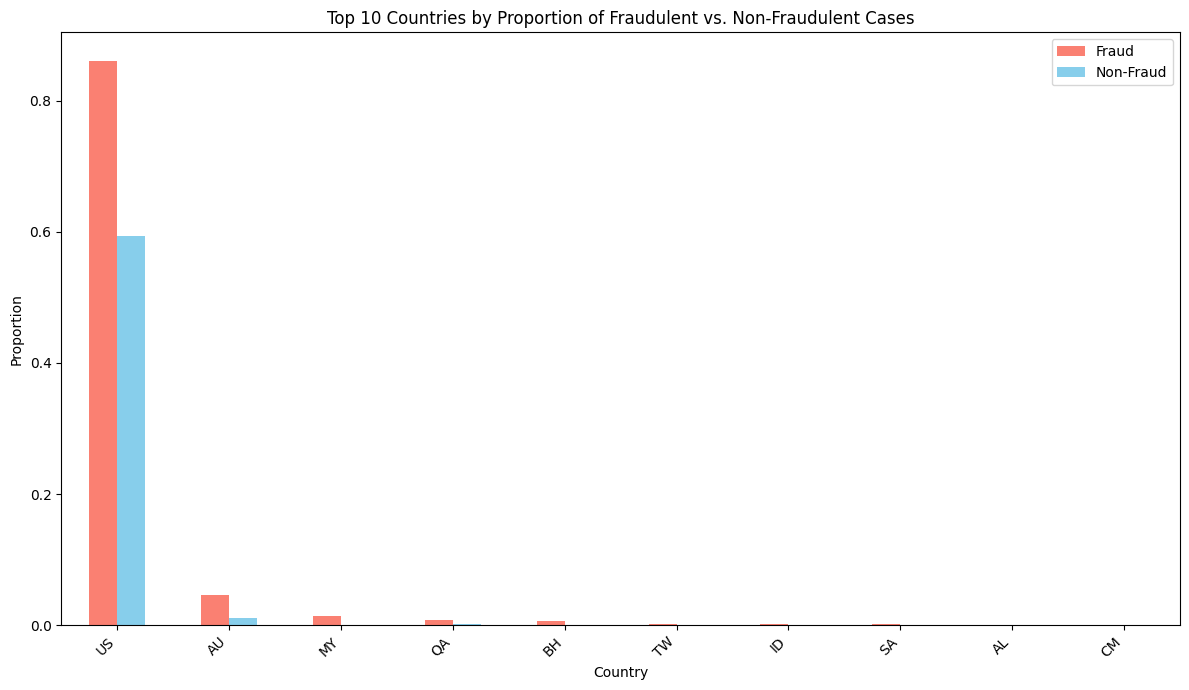

In [135]:
#Proportion by Country for Fraud vs Non-fraud
fraud_country_proportion = fraud_data['country'].value_counts(normalize=True)
non_fraud_country_proportion = non_fraud_data['country'].value_counts(normalize=True)

# Combine into a single DataFrame
country_proportions = pd.DataFrame({
    'Fraud': fraud_country_proportion,
    'Non-Fraud': non_fraud_country_proportion
}).fillna(0)  # Fill NaN with 0

# Filter out rows where both Fraud and Non-Fraud proportions are zero
country_proportions = country_proportions[(country_proportions['Fraud'] > 0) | (country_proportions['Non-Fraud'] > 0)]
country_proportions['Difference'] = country_proportions['Fraud'] - country_proportions['Non-Fraud']
top_10_countries_difference = country_proportions['Difference'].nlargest(10).index
country_proportions_top10 = country_proportions.loc[top_10_countries_difference]

# Plot
country_proportions_top10[['Fraud', 'Non-Fraud']].plot(kind='bar', figsize=(12, 7), color=['salmon', 'skyblue'])
plt.xlabel('Country')
plt.ylabel('Proportion')
plt.title('Top 10 Countries by Proportion of Fraudulent vs. Non-Fraudulent Cases')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



Dataset significantly dominated by US. Significantly more proportion of fraud in US and AU

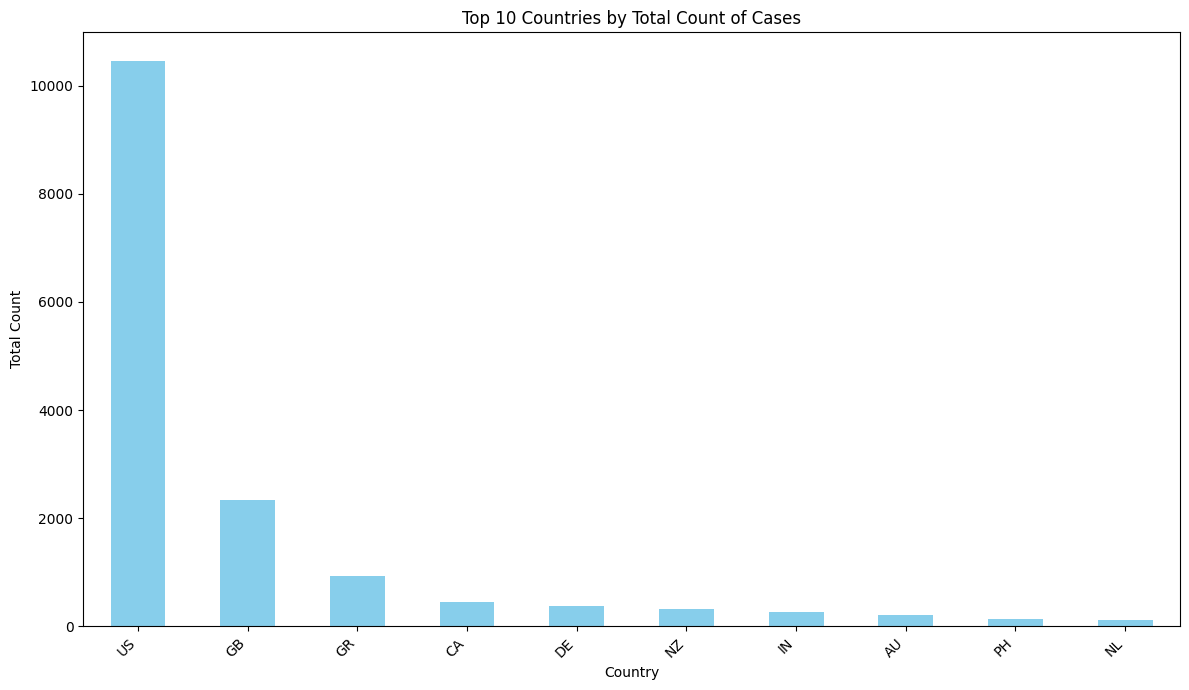

In [136]:
# Calculate total counts for each country (Fraud + Non-Fraud)
fraud_country_counts = fraud_data['country'].value_counts()
non_fraud_country_counts = non_fraud_data['country'].value_counts()
total_country_counts = fraud_country_counts.add(non_fraud_country_counts, fill_value=0).astype(int)

# Select the top 10 countries by total counts
top_10_countries = total_country_counts.nlargest(10)

# Plot
plt.figure(figsize=(12, 7))
top_10_countries.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('Total Count')
plt.title('Top 10 Countries by Total Count of Cases')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



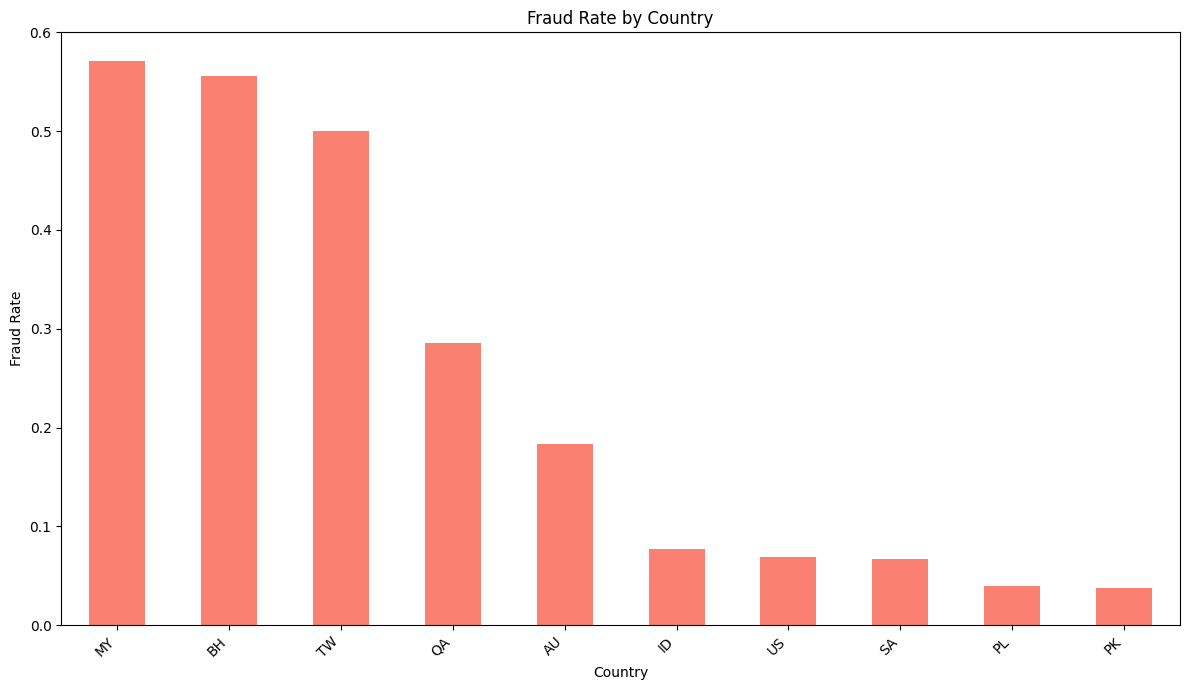

In [137]:
# Calculate counts for each function type in fraud and non-fraud data
fraud_country_counts = fraud_data['country'].value_counts()
non_fraud_country_counts = non_fraud_data['country'].value_counts()

# Combine fraud and non-fraud counts into a DataFrame
function_counts = pd.DataFrame({
    'Fraud': fraud_country_counts,
    'Non-Fraud': non_fraud_country_counts
}).fillna(0)

# Calculate total counts (Fraud + Non-Fraud)
function_counts['Total'] = function_counts['Fraud'] + function_counts['Non-Fraud']

# Calculate fraud rate for each function (Fraud / Total)
function_counts['Fraud Rate'] = function_counts['Fraud'] / function_counts['Total']

# Sort by Fraud Rate in descending order
function_counts_sorted = function_counts.sort_values(by='Fraud Rate', ascending=False).head(10)

# Plot Fraud Rate
function_counts_sorted['Fraud Rate'].plot(kind='bar', figsize=(12, 7), color='salmon')
plt.xlabel('Country')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Country')
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

Analysis based on countries is not very useful since majority of the job postings are from the US and fraud rate would be heavily skewed due to Law of Small Numbers.

### Telecommuting Analysis

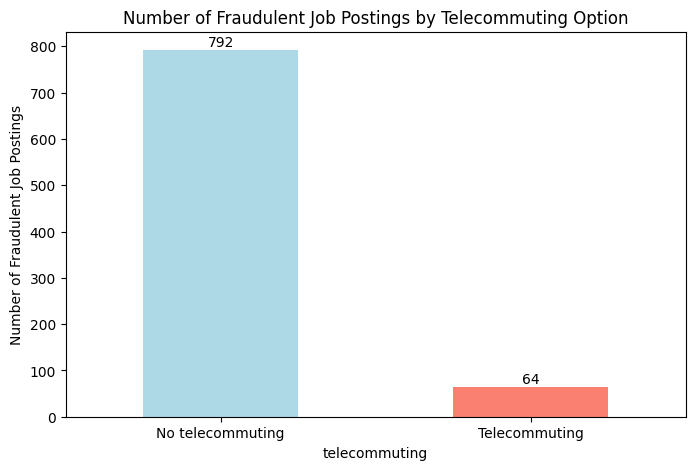

In [138]:

telecommuting_counts = fraud_data['telecommuting'].value_counts()

plt.figure(figsize=(8, 5))
telecommuting_counts.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Number of Fraudulent Job Postings by Telecommuting Option')
plt.ylabel('Number of Fraudulent Job Postings')
plt.xticks(ticks=[0, 1], labels=['No telecommuting', 'Telecommuting'], rotation=0)

for index, value in enumerate(telecommuting_counts):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

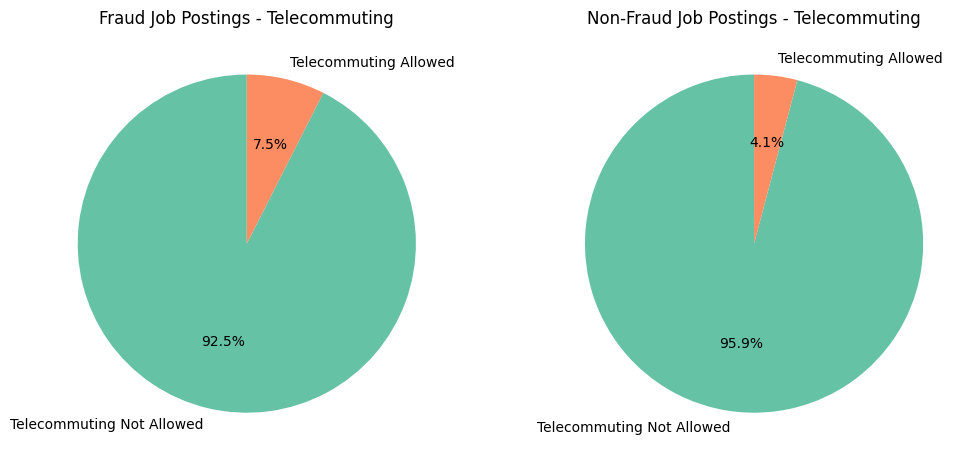

In [139]:
#Get count for telecommuting for Fraud & Non-Fraud
fraud_counts = fraud_data['telecommuting'].value_counts().sort_index()
non_fraud_counts = non_fraud_data['telecommuting'].value_counts().sort_index()

labels = ['Telecommuting Not Allowed', 'Telecommuting Allowed']
colors = ['#66c2a5', '#fc8d62']
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#Plot Fraud Cases for Telecommuting
ax[0].pie(fraud_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax[0].set_title('Fraud Job Postings - Telecommuting')

#Plot non-Fraud Cases for Telecommuting
ax[1].pie(non_fraud_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax[1].set_title('Non-Fraud Job Postings - Telecommuting')

plt.show()

In general, fraud job postings have a slightly higher chance of allowing telecommuting as compared to non-fraud job postings.

### Presence of Company Logo Analysis

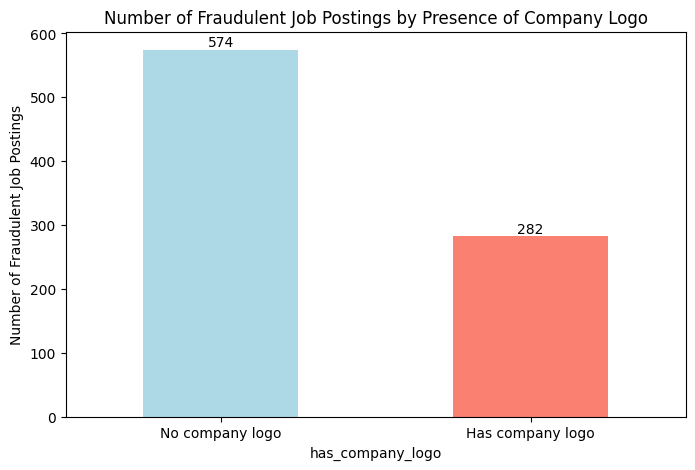

In [140]:
logo_counts = fraud_data['has_company_logo'].value_counts()

plt.figure(figsize=(8, 5))
logo_counts.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Number of Fraudulent Job Postings by Presence of Company Logo')
plt.ylabel('Number of Fraudulent Job Postings')
plt.xticks(ticks=[0, 1], labels=['No company logo', 'Has company logo'], rotation=0)

for index, value in enumerate(logo_counts):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

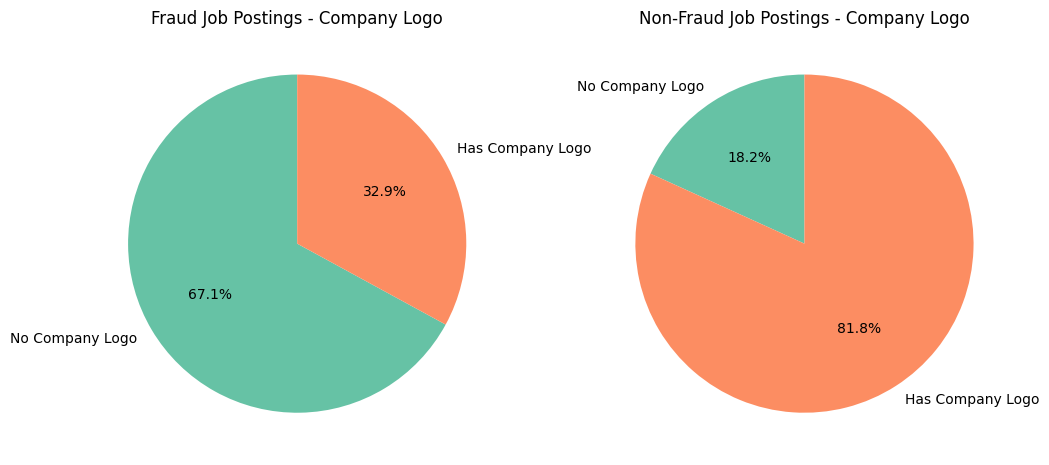

In [141]:
fraud_counts = fraud_data['has_company_logo'].value_counts().sort_index()
non_fraud_counts = non_fraud_data['has_company_logo'].value_counts().sort_index()

labels = ['No Company Logo', 'Has Company Logo']
colors = ['#66c2a5', '#fc8d62']
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].pie(fraud_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax[0].set_title('Fraud Job Postings - Company Logo')


ax[1].pie(non_fraud_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax[1].set_title('Non-Fraud Job Postings - Company Logo')

plt.show()

Fraud job postings have a higher chance of not having a company logo (67.3%) as compared to non-fraud job postings (18.1%).

### Questions Analysis

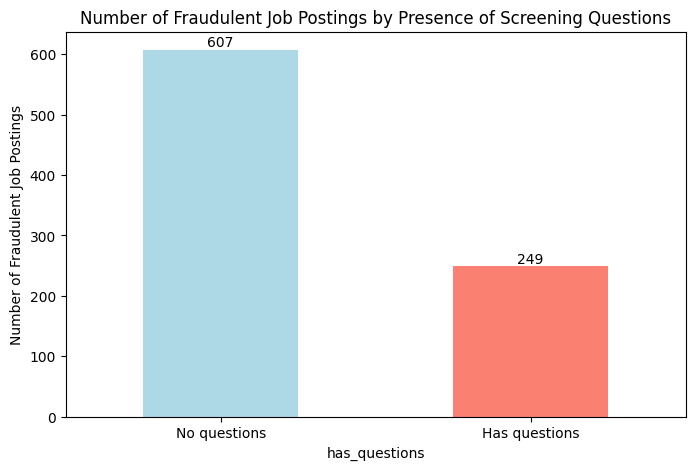

In [142]:
question_counts = fraud_data['has_questions'].value_counts()

plt.figure(figsize=(8, 5))
question_counts.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Number of Fraudulent Job Postings by Presence of Screening Questions')
plt.ylabel('Number of Fraudulent Job Postings')
plt.xticks(ticks=[0, 1], labels=['No questions', 'Has questions'], rotation=0)

for index, value in enumerate(question_counts):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

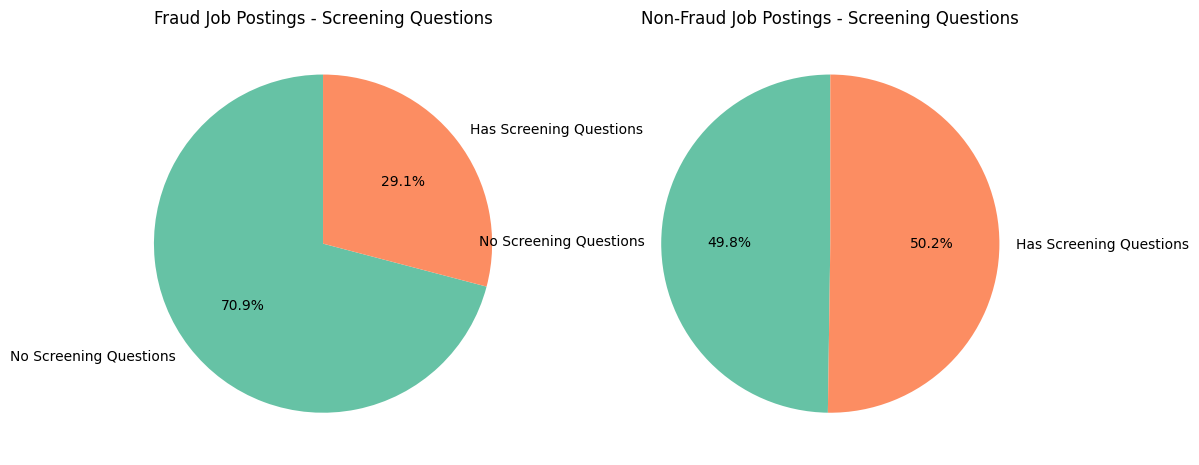

In [143]:
fraud_counts = fraud_data['has_questions'].value_counts().sort_index()
non_fraud_counts = non_fraud_data['has_questions'].value_counts().sort_index()

labels = ['No Screening Questions', 'Has Screening Questions']
colors = ['#66c2a5', '#fc8d62']
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].pie(fraud_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax[0].set_title('Fraud Job Postings - Screening Questions')

ax[1].pie(non_fraud_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax[1].set_title('Non-Fraud Job Postings - Screening Questions')

plt.show()

Fraud job postings have a higher chance of not having screening questions in the job posting (71.1%) as compared to non-fraud job postings (49.8%).

### Industry Analysis


In [144]:
print(f"Fraudulent proportion of Null Values for Industry: {fraud_data['industry'].isnull().sum()/len(fraud_data)}")
print(f"Non-Fraudulent proportion of Null Values for Industry: {non_fraud_data['industry'].isnull().sum()/len(non_fraud_data)}")

Fraudulent proportion of Null Values for Industry: 0.31542056074766356
Non-Fraudulent proportion of Null Values for Industry: 0.27277071014752435


In [145]:
df['industry'].nunique() #Too many categories

131

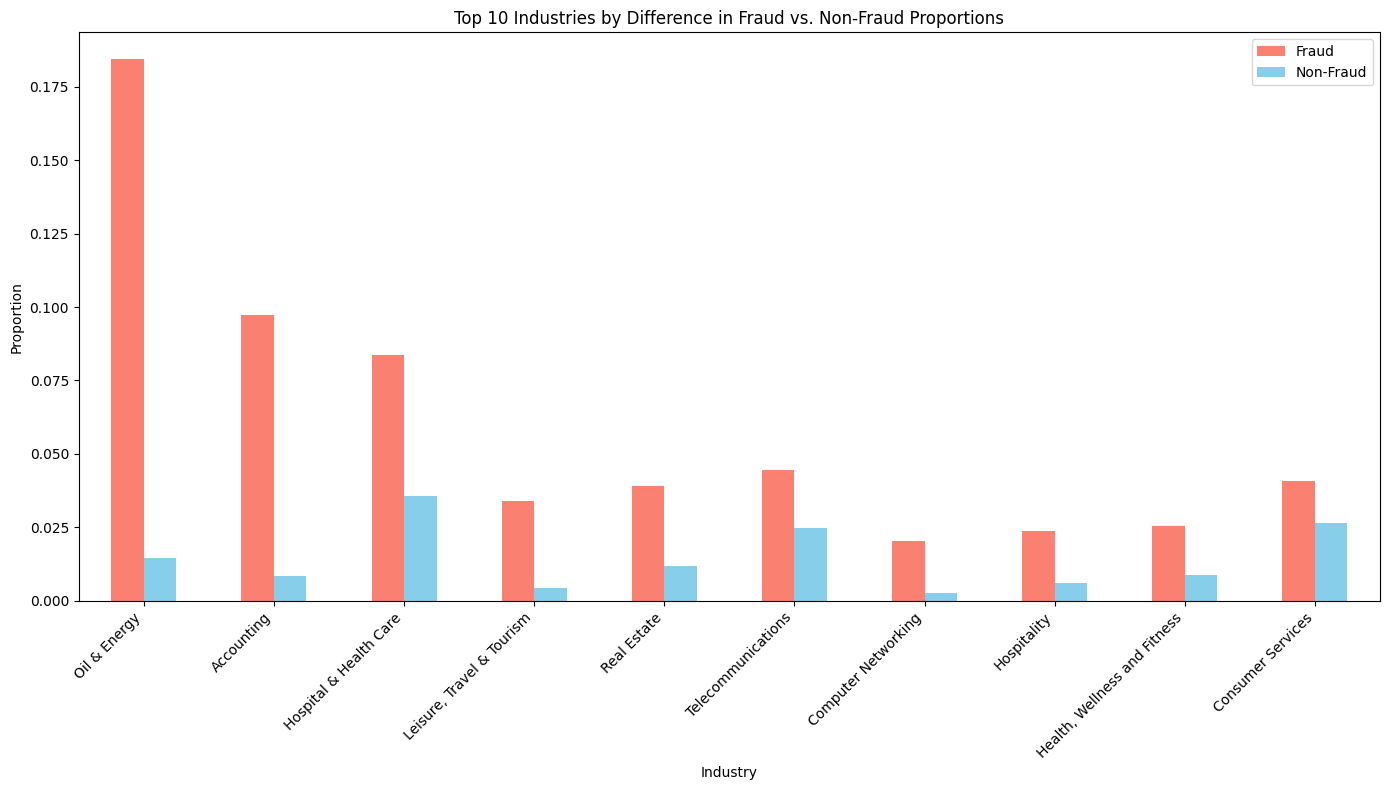

In [146]:
# Calculate proportions of Fraud vs Non-Fraud for Industry
fraud_industry_proportion = fraud_data['industry'].value_counts(normalize=True)
non_fraud_industry_proportion = non_fraud_data['industry'].value_counts(normalize=True)

industry_proportions = pd.DataFrame({
    'Fraud': fraud_industry_proportion,
    'Non-Fraud': non_fraud_industry_proportion
}).fillna(0)

# Calculate the absolute difference between Fraud and Non-Fraud proportions
industry_proportions['Difference'] = industry_proportions['Fraud'] - industry_proportions['Non-Fraud']

# Select the top 10 industries with the largest difference
top_10_difference = industry_proportions['Difference'].nlargest(10).index
industry_proportions_top10 = industry_proportions.loc[top_10_difference]

# Plot
industry_proportions_top10[['Fraud', 'Non-Fraud']].plot(kind='bar', figsize=(14, 8), color=['salmon', 'skyblue'])
plt.xlabel('Industry')
plt.ylabel('Proportion')
plt.title('Top 10 Industries by Difference in Fraud vs. Non-Fraud Proportions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Certain categories have way higher proportion of fraud as seen in the graph, but no conclusion can be drawn yet. Let's further analyse based on counts and fraud rate

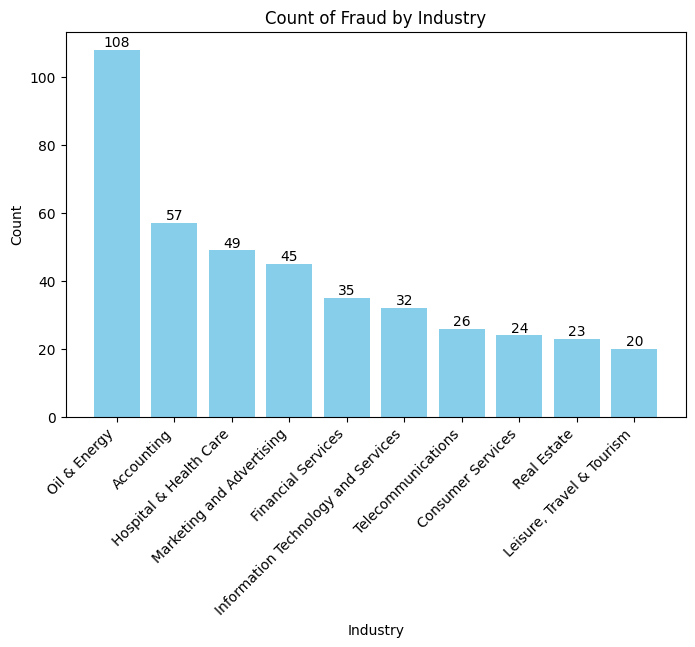

In [147]:
# Count occurrences of each industry
industry_counts = df.groupby('industry')['fraudulent'].sum()
top_10_industries = industry_counts.sort_values(ascending=False).head(10)
# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(top_10_industries.index, top_10_industries.values, color='skyblue')

# Add labels and title
plt.xlabel('Industry')
plt.ylabel('Count')
plt.title('Count of Fraud by Industry')
plt.xticks(rotation=45, ha='right')


# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

# Show plot
plt.show()

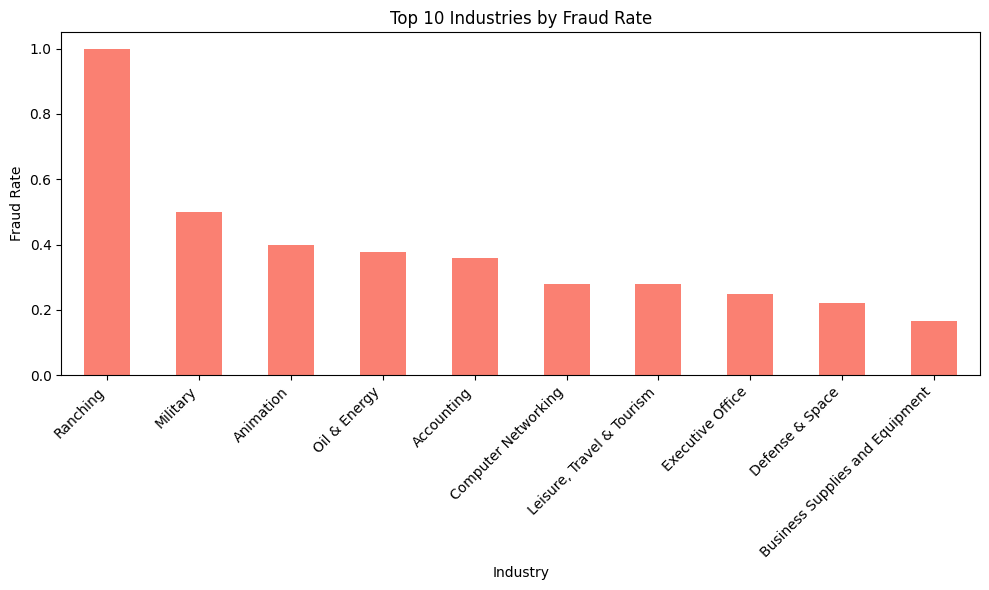

In [148]:
industry_fraud_rate = df.groupby('industry')['fraudulent'].mean()

# Select the top 10 industries with the highest fraud rate
top_10_industries = industry_fraud_rate.sort_values(ascending=False).head(10)

# Plotting the top 10 fraud rates
plt.figure(figsize=(10, 6))
top_10_industries.plot(kind='bar', color='salmon')
plt.title('Top 10 Industries by Fraud Rate')
plt.xlabel('Industry')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

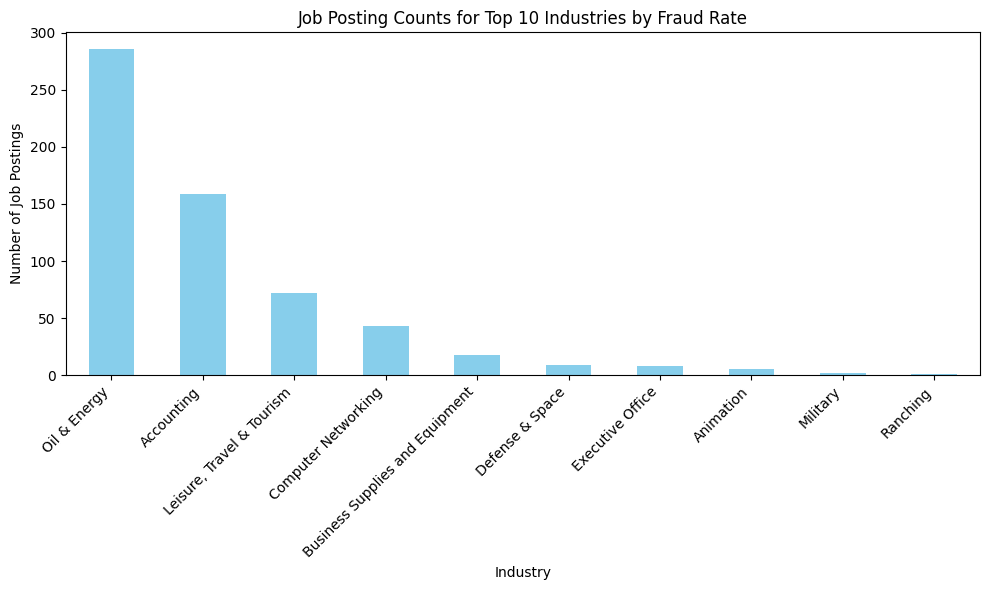

industry
Oil & Energy                       286
Accounting                         159
Leisure, Travel & Tourism           72
Computer Networking                 43
Business Supplies and Equipment     18
Defense & Space                      9
Executive Office                     8
Animation                            5
Military                             2
Ranching                             1
Name: count, dtype: int64


In [149]:
# Filter the original DataFrame to include only job postings in the top 10 industries
top_10_industries = industry_fraud_rate.sort_values(ascending=False).head(10).index
top_10_data = df[df['industry'].isin(top_10_industries)]

# Calculate the count of job postings for each of the top 10 industries
industry_posting_count = top_10_data['industry'].value_counts()

# Plotting the job posting counts
plt.figure(figsize=(10, 6))
industry_posting_count.plot(kind='bar', color='skyblue')
plt.title('Job Posting Counts for Top 10 Industries by Fraud Rate')
plt.xlabel('Industry')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
print(industry_posting_count)

The high fraud rate of the ranching, military, animation, investment management, executive office and defense & space industry is skewed by the low job posting count. Therefore, we will only consider 4 industries i.e. Oil & Energy, Accounting, Leisure, Travel & Tourism and Computer Networking with higher fraud rate as compared to other industries.

### Education Analysis

In [150]:
print(f"Fraudulent proportion of Null Values for Education Requirement: {fraud_data['required_education'].isnull().sum()/len(fraud_data)}")
print(f"Non-Fraudulent proportion of Null Values for Education Requirement: {non_fraud_data['required_education'].isnull().sum()/len(non_fraud_data)}")

Fraudulent proportion of Null Values for Education Requirement: 0.5186915887850467
Non-Fraudulent proportion of Null Values for Education Requirement: 0.45183061577972883


In [151]:
df['required_education'].nunique()

13

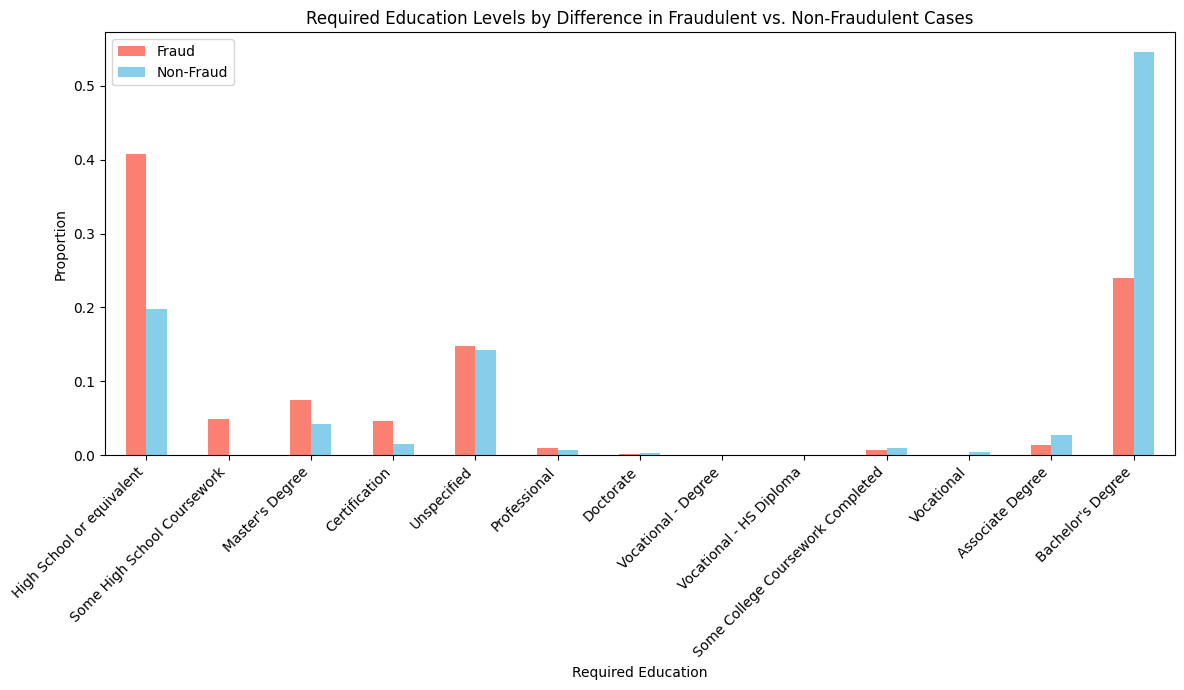

In [152]:
# Calculate proportions of each education level for fraud and non-fraud data
fraud_education_proportion = fraud_data['required_education'].value_counts(normalize=True)
non_fraud_education_proportion = non_fraud_data['required_education'].value_counts(normalize=True)

education_proportions = pd.DataFrame({
    'Fraud': fraud_education_proportion,
    'Non-Fraud': non_fraud_education_proportion
}).fillna(0)

education_proportions['Difference'] = education_proportions['Fraud'] - education_proportions['Non-Fraud']
top_education_difference = education_proportions['Difference'].nlargest(15).index
education_proportions_top = education_proportions.loc[top_education_difference]

education_proportions_top[['Fraud', 'Non-Fraud']].plot(kind='bar', figsize=(12, 7), color=['salmon', 'skyblue'])
plt.xlabel('Required Education')
plt.ylabel('Proportion')
plt.title('Required Education Levels by Difference in Fraudulent vs. Non-Fraudulent Cases')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

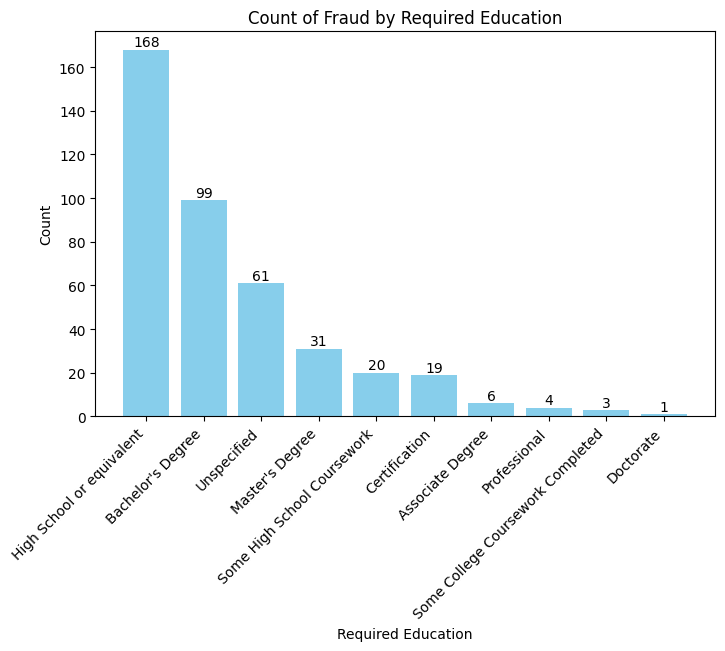

In [153]:
# Count occurrences of each industry
edu_counts = df.groupby('required_education')['fraudulent'].sum()
top_10_edu = edu_counts.sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(top_10_edu.index, top_10_edu.values, color='skyblue')

# Add labels and title
plt.xlabel('Required Education')
plt.ylabel('Count')
plt.title('Count of Fraud by Required Education')
plt.xticks(rotation=45, ha='right')


# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

# Show plot
plt.show()

required_education
Some High School Coursework          0.740741
Certification                        0.115152
High School or equivalent            0.084465
Master's Degree                      0.074519
Professional                         0.054795
Unspecified                          0.044558
Doctorate                            0.038462
Some College Coursework Completed    0.030000
Associate Degree                     0.022727
Bachelor's Degree                    0.019416
Vocational                           0.000000
Vocational - Degree                  0.000000
Vocational - HS Diploma              0.000000
Name: fraudulent, dtype: float64


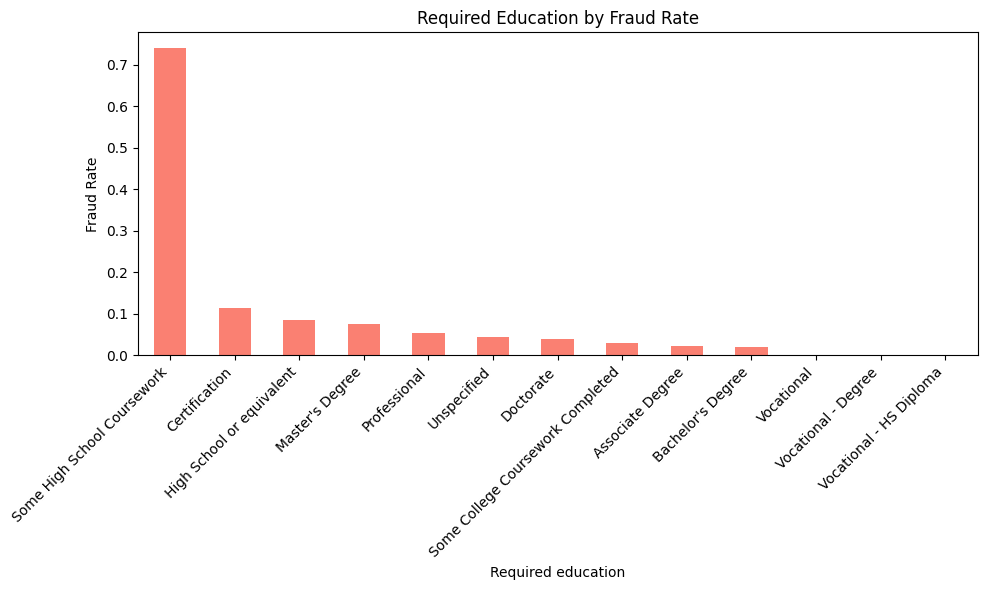

In [154]:
education_fraud_rate = df.groupby('required_education')['fraudulent'].mean().sort_values(ascending=False)
print(education_fraud_rate)

# Plotting the fraud rates
plt.figure(figsize=(10, 6))
education_fraud_rate.plot(kind='bar', color='salmon')
plt.title('Required Education by Fraud Rate')
plt.xlabel('Required education')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

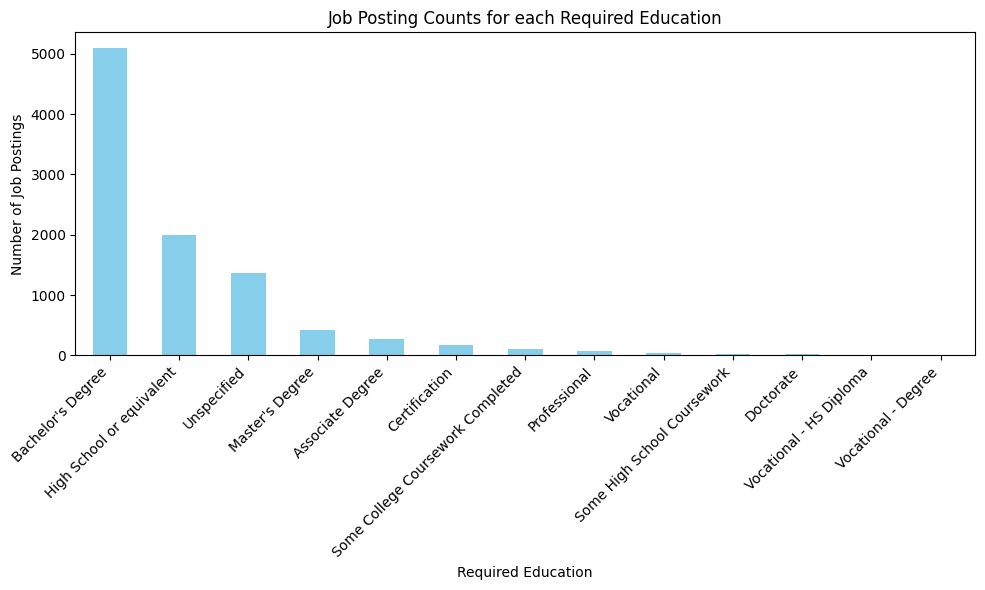

required_education
Bachelor's Degree                    5099
High School or equivalent            1989
Unspecified                          1369
Master's Degree                       416
Associate Degree                      264
Certification                         165
Some College Coursework Completed     100
Professional                           73
Vocational                             47
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: count, dtype: int64


In [155]:
education_posting_count = df['required_education'].value_counts()

# Plotting the job posting counts
plt.figure(figsize=(10, 6))
education_posting_count.plot(kind='bar', color='skyblue')
plt.title('Job Posting Counts for each Required Education')
plt.xlabel('Required Education')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
print(education_posting_count)

'Some High School Coursework' has a fraud rate of 0.74 and the total number of job postings with this education requirement is 27. Out of this 27 job postings, 20 were fraud and all these fraud postings are by an anonymous company and the requirements of the job are the same "Home Office SuppliesComputer with internet accessQuiet work area away from distractionsMust be able to work independently and get the job done with little guidance."

Other required education such as "Certification", "High School or equivalent" and "Master's Degree" have a slightly higher fraud rate as compared to other required education.

### Employment Type Analysis

In [156]:
print(f"Fraudulent proportion of Null Values for Employment type : {fraud_data['employment_type'].isnull().sum()/len(fraud_data)}")
print(f"Non-Fraudulent proportion of Null Values for Employment type: {non_fraud_data['employment_type'].isnull().sum()/len(non_fraud_data)}")

Fraudulent proportion of Null Values for Employment type : 0.2757009345794392
Non-Fraudulent proportion of Null Values for Employment type: 0.19064683748432182


In [157]:
df['employment_type'].nunique()

5

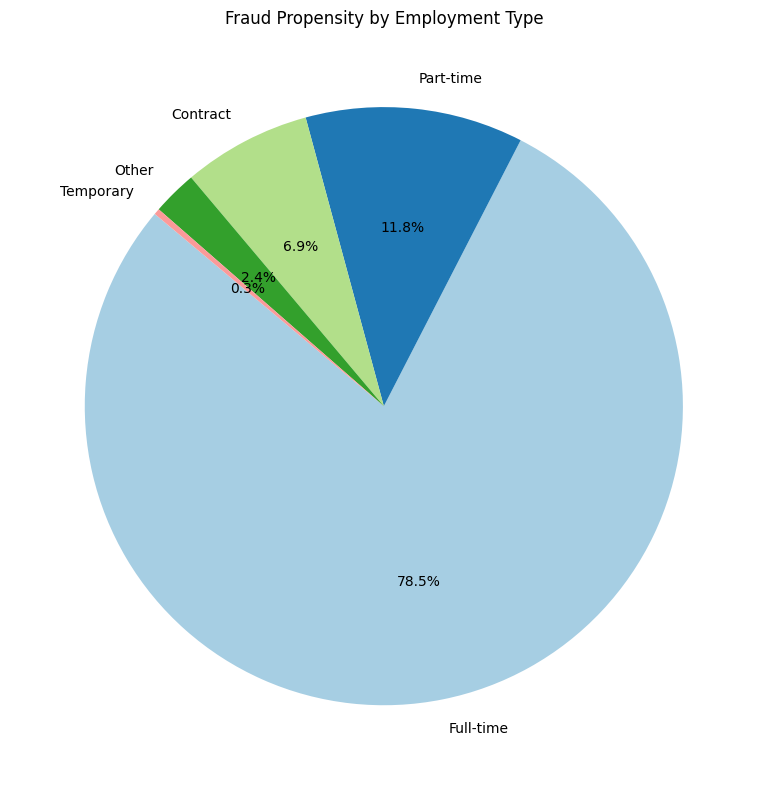

In [158]:
# Calculate fraud case proportions within total fraud cases
fraud_employment_proportion = fraud_data['employment_type'].value_counts(normalize=True) * 100  # Convert to percentage

# Sort proportions and filter if there are too many categories
fraud_employment_proportion = fraud_employment_proportion.sort_values(ascending=False)

# Plot as a pie chart
plt.figure(figsize=(10, 8))
plt.pie(fraud_employment_proportion, labels=fraud_employment_proportion.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Fraud Propensity by Employment Type')
plt.tight_layout()
plt.show()

From the pie chart, we can see that full-time employment type takes up the majority of fraud cases. However, it could be down to the higher number of full time jobs. Hence, our next step is to analyze fraud proportions within each employment type to get a better sense of which employment type is more susceptible to fraud.

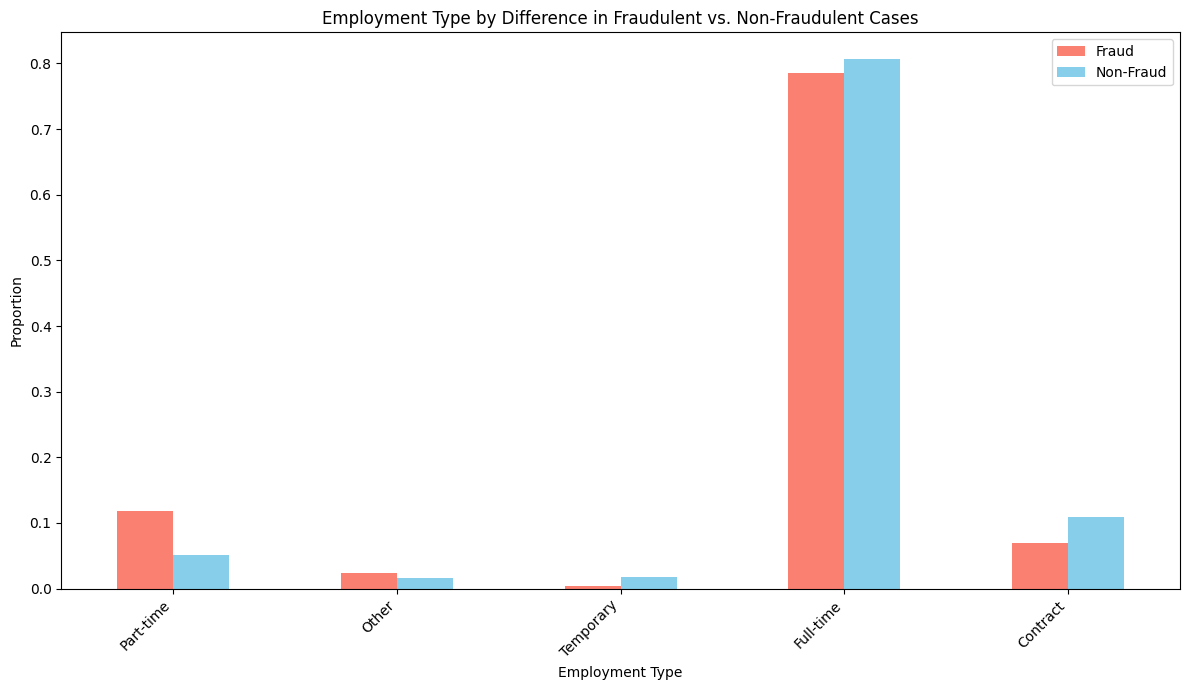

In [159]:
# Calculate proportions of each employment type for fraud and non-fraud data
fraud_employment_proportion = fraud_data['employment_type'].value_counts(normalize=True)
non_fraud_employment_proportion = non_fraud_data['employment_type'].value_counts(normalize=True)

employment_proportions = pd.DataFrame({
    'Fraud': fraud_employment_proportion,
    'Non-Fraud': non_fraud_employment_proportion
}).fillna(0)

employment_proportions['Difference'] = employment_proportions['Fraud'] - employment_proportions['Non-Fraud']
top_employment_difference = employment_proportions['Difference'].nlargest(15).index
employment_proportions_top = employment_proportions.loc[top_employment_difference]

employment_proportions_top[['Fraud', 'Non-Fraud']].plot(kind='bar', figsize=(12, 7), color=['salmon', 'skyblue'])
plt.xlabel('Employment Type')
plt.ylabel('Proportion')
plt.title('Employment Type by Difference in Fraudulent vs. Non-Fraudulent Cases')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

From the graph, we see that there is a higher fraud proportion for "Part-time" and "Other" employment type.

employment_type
Contract      1514
Full-time    11423
Other          225
Part-time      772
Temporary      237
Name: count, dtype: int64
employment_type
Full-time    487
Part-time     73
Contract      43
Other         15
Temporary      2
Name: count, dtype: int64
employment_type
Part-time    0.094560
Other        0.066667
Full-time    0.042633
Contract     0.028402
Temporary    0.008439
Name: fraudulent, dtype: float64


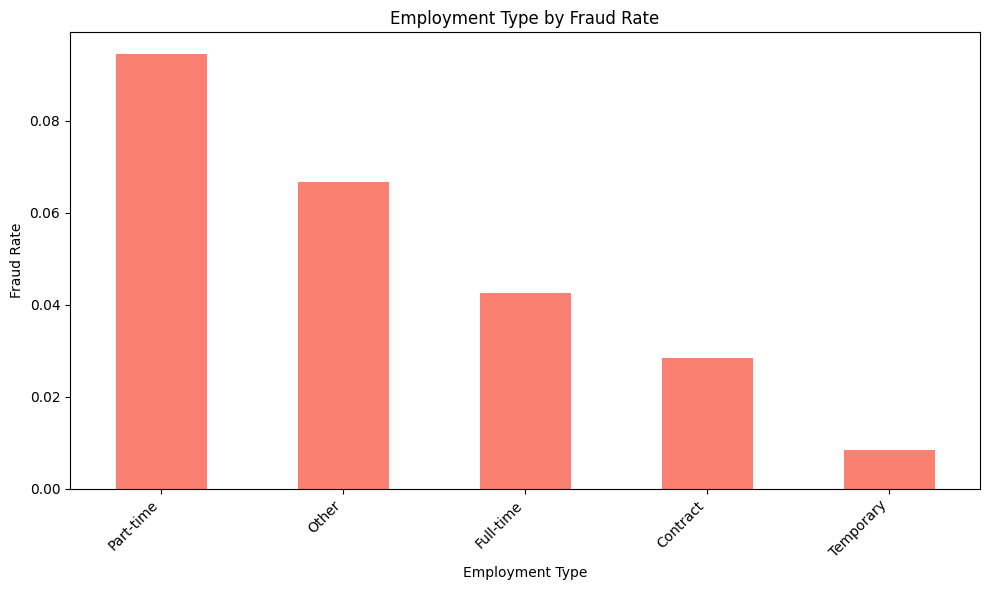

In [160]:
# Calculate the total cases and fraud cases per employment type
total_cases = non_fraud_data['employment_type'].value_counts() + fraud_data['employment_type'].value_counts()
fraud_cases = fraud_data['employment_type'].value_counts()
print(total_cases)
print(fraud_cases)

employ_fraud_rate = df.groupby('employment_type')['fraudulent'].mean().sort_values(ascending=False)
print(employ_fraud_rate)

# Plotting the fraud rates
plt.figure(figsize=(10, 6))
employ_fraud_rate.plot(kind='bar', color='salmon')
plt.title('Employment Type by Fraud Rate')
plt.xlabel('Employment Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

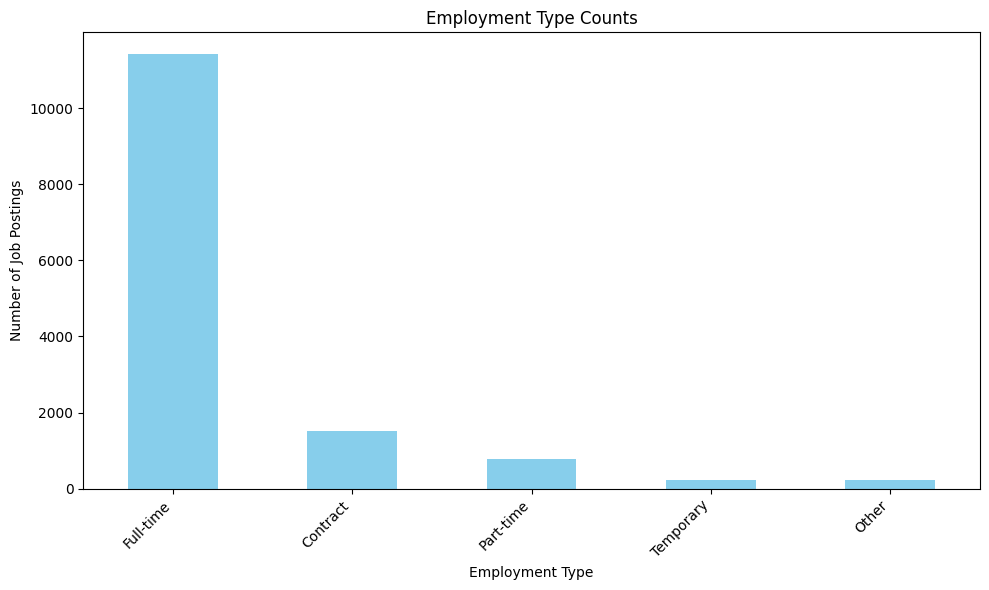

employment_type
Full-time    11423
Contract      1514
Part-time      772
Temporary      237
Other          225
Name: count, dtype: int64


In [161]:
# Filter the original DataFrame to include only job postings in the top 10 industries
employments = employ_fraud_rate.sort_values(ascending=False).index
employ_data = df[df['employment_type'].isin(employments)]

# Calculate the count of job postings for each of the top 10 industries
employ_posting_count = employ_data['employment_type'].value_counts()

# Plotting the job posting counts
plt.figure(figsize=(10, 6))
employ_posting_count.plot(kind='bar', color='skyblue')
plt.title('Employment Type Counts')
plt.xlabel('Employment Type')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
print(employ_posting_count)

Based on observations from both fraud rate and total counts, full-time job postings have a lower propensity for fraud and part-time job postings have a higher propensity for fraud

### Required Experience Analysis

In [162]:
print(f"Fraudulent proportion of Null Values for required experience: {fraud_data['required_experience'].isnull().sum()/len(fraud_data)}")
print(f"Non-Fraudulent proportion of Null Values for required experience: {non_fraud_data['required_experience'].isnull().sum()/len(non_fraud_data)}")

Fraudulent proportion of Null Values for required experience: 0.49883177570093457
Non-Fraudulent proportion of Null Values for required experience: 0.3903123693483844


In [163]:
df['required_experience'].nunique()

7

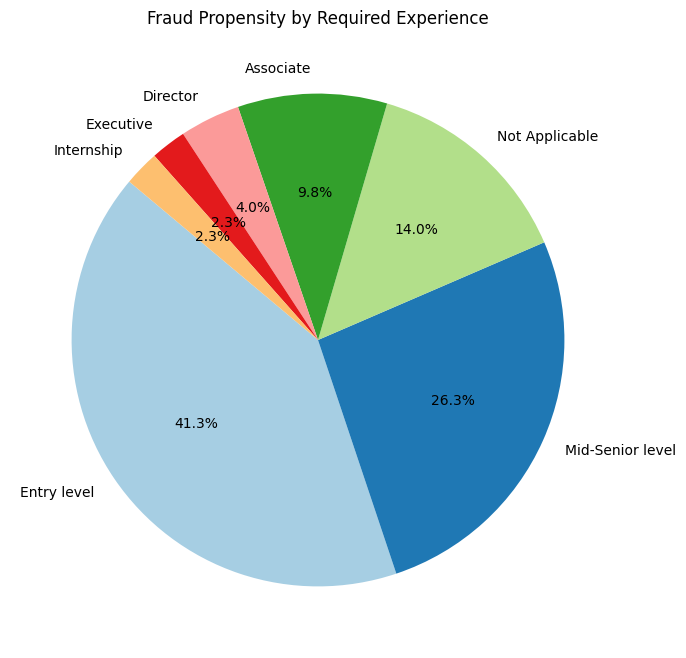

In [164]:
# Calculate experience required case proportions within total fraud cases
fraud_exp_proportion = fraud_data['required_experience'].value_counts(normalize=True) * 100  # Convert to percentage

# Sort proportions and filter if there are too many categories
fraud_exp_proportion = fraud_exp_proportion.sort_values(ascending=False)

# Plot as a pie chart
plt.figure(figsize=(10, 8))
plt.pie(fraud_exp_proportion, labels=fraud_exp_proportion.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Fraud Propensity by Required Experience')
plt.show()

From the pie chart, we can see that Entry level and Mid-Senior level required experience type takes up the majority of fraud cases. However, it could be down to the higher number of such categories. Hence, our next step is to analyze fraud proportions within each requried experience type to get a better sense of which type is more susceptible to fraud.

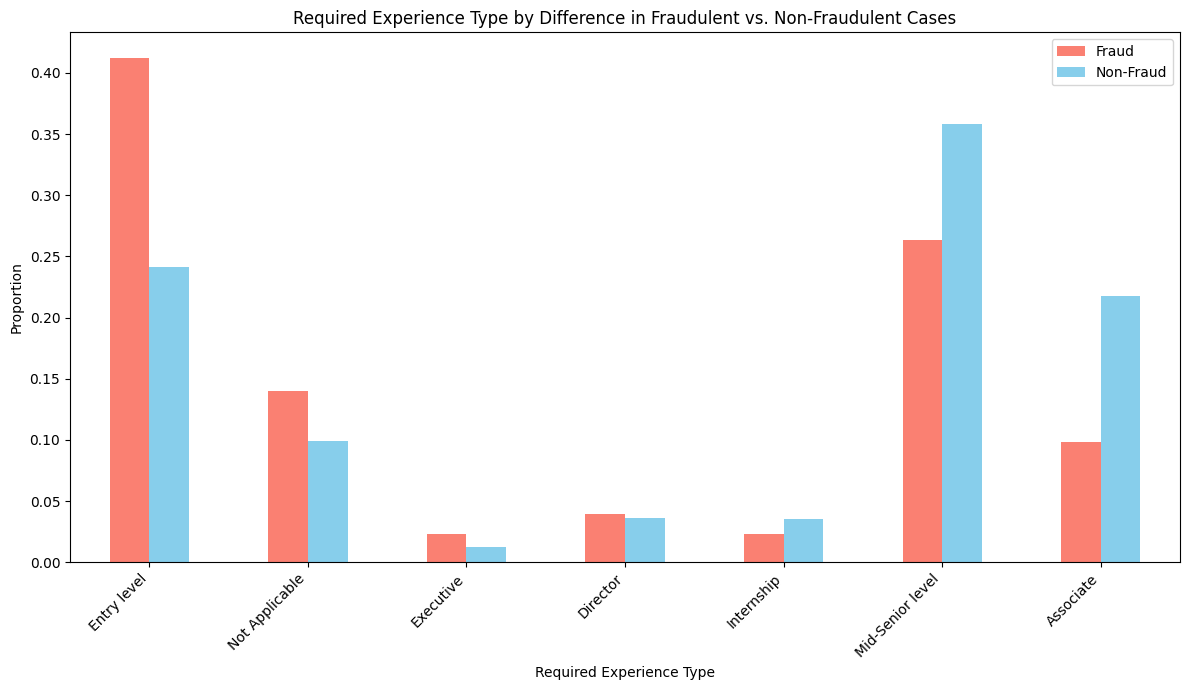

In [165]:
# Calculate proportions of each required experience type for fraud and non-fraud data
fraud_exp_proportion = fraud_data['required_experience'].value_counts(normalize=True)
non_fraud_exp_proportion = non_fraud_data['required_experience'].value_counts(normalize=True)

exp_proportions = pd.DataFrame({
    'Fraud': fraud_exp_proportion,
    'Non-Fraud': non_fraud_exp_proportion
}).fillna(0)

exp_proportions['Difference'] = exp_proportions['Fraud'] - exp_proportions['Non-Fraud']
top_exp_difference = exp_proportions['Difference'].nlargest(15).index
exp_proportions_top = exp_proportions.loc[top_exp_difference]

exp_proportions_top[['Fraud', 'Non-Fraud']].plot(kind='bar', figsize=(12, 7), color=['salmon', 'skyblue'])
plt.xlabel('Required Experience Type')
plt.ylabel('Proportion')
plt.title('Required Experience Type by Difference in Fraudulent vs. Non-Fraudulent Cases')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

From the graph, we see that there is a higher fraud proportion for "Entry-level","Not Applicable" and "Executive" required experience type.

required_experience
Associate           2267
Director             383
Entry level         2637
Executive            140
Internship           372
Mid-Senior level    3768
Not Applicable      1070
Name: count, dtype: int64
required_experience
Entry level         177
Mid-Senior level    113
Not Applicable       60
Associate            42
Director             17
Executive            10
Internship           10
Name: count, dtype: int64
required_experience
Executive           0.071429
Entry level         0.067122
Not Applicable      0.056075
Director            0.044386
Mid-Senior level    0.029989
Internship          0.026882
Associate           0.018527
Name: fraudulent, dtype: float64


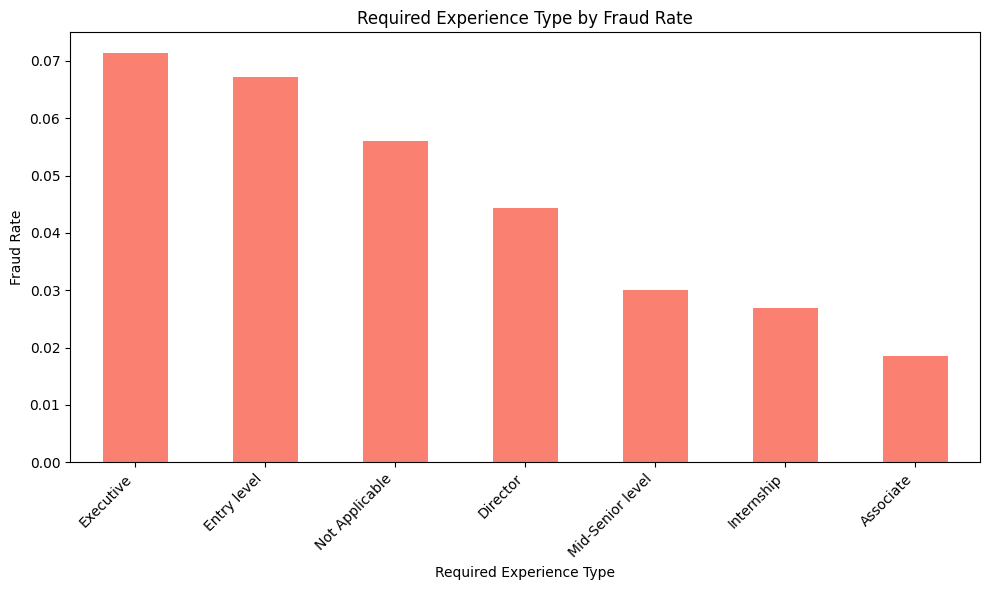

In [166]:
# Calculate the total cases and fraud cases per experience type
total_cases = non_fraud_data['required_experience'].value_counts() + fraud_data['required_experience'].value_counts()
fraud_cases = fraud_data['required_experience'].value_counts()
print(total_cases)
print(fraud_cases)

exp_fraud_rate = df.groupby('required_experience')['fraudulent'].mean().sort_values(ascending=False)
print(exp_fraud_rate)
# Plotting the fraud rates
plt.figure(figsize=(10, 6))
exp_fraud_rate.plot(kind='bar', color='salmon')
plt.title('Required Experience Type by Fraud Rate')
plt.xlabel('Required Experience Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

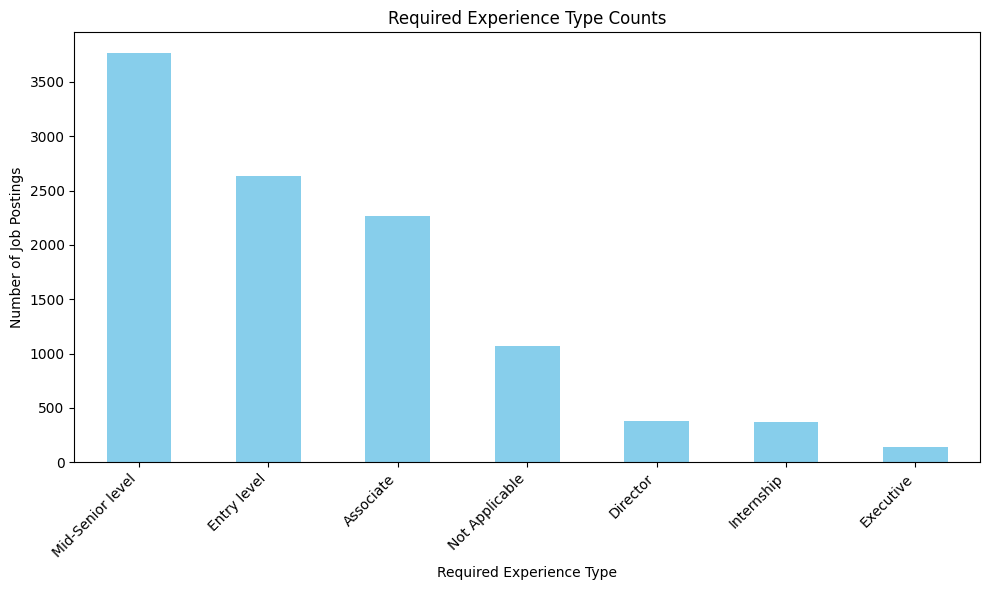

employment_type
Full-time    11423
Contract      1514
Part-time      772
Temporary      237
Other          225
Name: count, dtype: int64


In [167]:
# Filter the original DataFrame to include only job postings in the top 10 industries
exp = exp_fraud_rate.sort_values(ascending=False).index
exp_data = df[df['required_experience'].isin(exp)]

# Calculate the count of job postings for each of the top 10 industries
exp_posting_count = exp_data['required_experience'].value_counts()

# Plotting the job posting counts
plt.figure(figsize=(10, 6))
exp_posting_count.plot(kind='bar', color='skyblue')
plt.title('Required Experience Type Counts')
plt.xlabel('Required Experience Type')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
print(employ_posting_count)

Based on observations from both fraud rate and total counts, entry level positions are at a higher propensity for fraud.

#### Most Salient Features so Far

> Add blockquote


* Presence of Screening Questions
* Company Logo
* Certain functions (Engineering, Accounting/Auditing) have higher proportions of Fraud
* A few countries (US, AU, MY) have higher proportions of Fraud
* Industry and Education have higher Null value proportions when it comes to Fraud data
* Higher fraud proportion for High school related and Master's education requirements, Lower fraud proportion for Associate's and Bachelor's Degrees
* Many categories of Industry have relatively high Fraud proportion
* Higher fraud proportions for required experience: entry level positions
Note: Should account for Null values as well

# Data Preprocessing


## Text Cleaning

In [168]:
textual_columns=['title', 'company_profile', 'description', 'requirements', 'benefits']
pd.set_option('display.max_colwidth', None)
df[textual_columns+['fraudulent']]

title  \
0                                                 Marketing Intern   
1                        Customer Service - Cloud Video Production   
2                          Commissioning Machinery Assistant (CMA)   
3                                Account Executive - Washington DC   
4                                              Bill Review Manager   
...                                                            ...   
17875                             Account Director - Distribution    
17876                                           Payroll Accountant   
17877  Project Cost Control Staff Engineer - Cost Control Exp - TX   
17878                                             Graphic Designer   
17879                                   Web Application Developers   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      company_profile  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [169]:
nlp = spacy.load("en_core_web_sm")
def clean_text(text):
    if pd.isnull(text):
        return ""

    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text) #Removes all Symbols & Punctuation
    text = re.sub(r"http\S+|www\S+|#URL_[a-f0-9]+", "", text)  # Remove URLs
    text = re.sub(r"&\w+;", " ", text)                         # Remove HTML entities
    text = re.sub(r"\s+", " ", text).strip()                   # Normalise whitespace

    doc = nlp(text)
    cleaned_tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha
    ]

    return " ".join(cleaned_tokens)

In [170]:
textual_columns

['title', 'company_profile', 'description', 'requirements', 'benefits']

### Code to Create cleaned dataframe (Already Provided in Submission)

In [171]:
'''
df['cleaned_title']=df['title'].apply(clean_text)
df['cleaned_company_profile']=df['company_profile'].apply(clean_text)
df['cleaned_description']=df['description'].apply(clean_text)
df['cleaned_requirements']=df['requirements'].apply(clean_text)
df['cleaned_benefits']=df['benefits'].apply(clean_text)
'''

"\ndf['cleaned_title']=df['title'].apply(clean_text)\ndf['cleaned_company_profile']=df['company_profile'].apply(clean_text)\ndf['cleaned_description']=df['description'].apply(clean_text)\ndf['cleaned_requirements']=df['requirements'].apply(clean_text)\ndf['cleaned_benefits']=df['benefits'].apply(clean_text)\n"

In [172]:
'''df.to_csv('drive/MyDrive/BT4012/cleaned_data_jobs.csv', index=False)'''

"df.to_csv('drive/MyDrive/BT4012/cleaned_data_jobs.csv', index=False)"

## Read Cleaned Text



In [173]:
cleaned_df=pd.read_csv('/content/drive/MyDrive/BT4012/cleaned_data_jobs.csv')
#Drop Duplicate Rows
cleaned_df=cleaned_df.drop(columns='job_id')
cleaned_df.drop_duplicates(inplace=True)
cleaned_df.shape

(17599, 22)

In [174]:
cleaned_df.dtypes

title                      object
location                   object
department                 object
salary_range               object
company_profile            object
description                object
requirements               object
benefits                   object
telecommuting               int64
has_company_logo            int64
has_questions               int64
employment_type            object
required_experience        object
required_education         object
industry                   object
function                   object
fraudulent                  int64
cleaned_title              object
cleaned_company_profile    object
cleaned_description        object
cleaned_requirements       object
cleaned_benefits           object
dtype: object

In [175]:
pd.set_option('display.max_colwidth', 1000)
cleaned_df[['cleaned_company_profile', 'company_profile', ]]

cleaned_company_profile  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ve create groundbreaking award win cook site support connect celebrate home cook need place editorial business engineering team focus technology find new well way connect people specific food interest offer superb highly curate information food cooking attract talented home cook contributor country publish know professional like mario batali gwyneth paltrow danny meyer partnership food market random house name good food website james beard foundation iacp feature new york times npr pando daily techcrunch today locate chelsea new york city   
1                                                                                                                                                                                                                                                                                                                                   second world cloud video production service second world cloud video production service enable brand agency high quality online video content shoot produce world second make video production fast affordable manage seamlessly cloud purchase publish http second remove hassle cost risk speed issue work regular video production company manage aspect video project beautiful online experience grow global network rate video professional country manage dedicated production success team country second provide success guarantee second produce video country global brand include world large include paypal l oreal sony barclay office auckland london sydney tokyo singapore http http http   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                      valor service provide workforce solution meet need company private sector special focus oil amp gas industry valor service involve step hiring process remain contact way final step signing employment contract new employer valor service found vision employ unique skill experience quality america s fine veteran provide private sector company precise concerted value add service america s fine veteran optimize career opportunity eager word veteran ample opportunity employment private sector ideal candidate fill position valor service success mission   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 passion improve quality life geography heart esri s geographic information system gis technology inspire enable government university business worldwide save money life environment deep understanding change world carefully manage growth zero debt esri stability uncommon today s volatile business world privately hold offer exceptional benefit competitive salary k 

## Textual Analysis

Functions to Generate Word Cloud and Bar Chart by word occurances

In [176]:
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plotting the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis lines and labels
    plt.title(title)
    plt.show()


In [177]:
def get_word_frequencies(text):
    # Tokenize by splitting on spaces
    words = text.split()

    # Count word frequencies using Counter from collections
    word_counts = Counter(words)

    # Convert to a DataFrame for easier plotting
    word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

    # Sort by count in descending order and return top 20 words
    return word_freq_df.sort_values(by='count', ascending=False).head(20)

# Function to plot word frequencies
def plot_word_frequencies(word_freq_df, title):
    plt.figure(figsize=(10, 6))

    # Create a barplot
    plt.barh(word_freq_df['word'], word_freq_df['count'], color='skyblue')

    # Add labels and title
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(title)

    # Invert y-axis so the highest frequency words are at the top
    plt.gca().invert_yaxis()

    # Show the plot
    plt.show()

### Cleaned Job Title Analysis

In [178]:
#nonfraud text
cleaned_df_nonfraud = cleaned_df[cleaned_df['fraudulent'] == 0]
cleaned_text_nonfraud = ' '.join(cleaned_df_nonfraud['cleaned_title'].dropna())

#fraud text
cleaned_df_fraud = cleaned_df[cleaned_df['fraudulent'] == 1]
cleaned_text_fraud = ' '.join(cleaned_df_fraud['cleaned_title'].dropna())

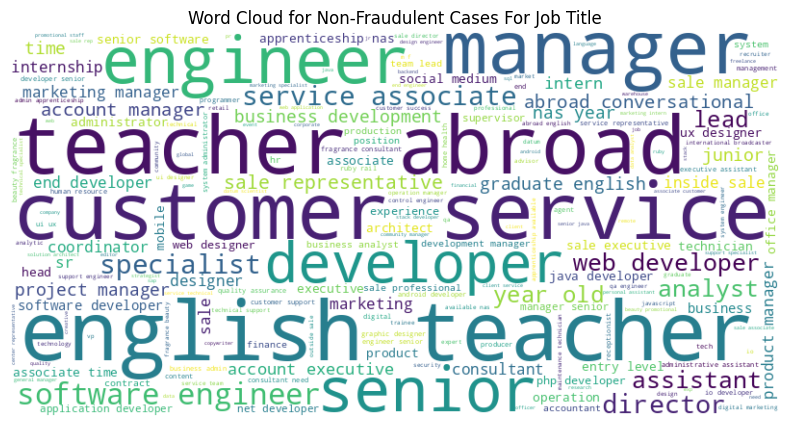

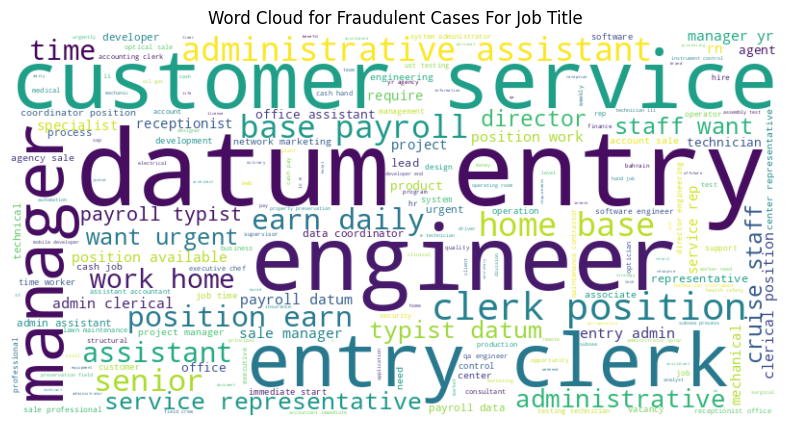

In [179]:
# Generate and display word cloud for fraudulent == 0
generate_word_cloud(cleaned_text_nonfraud, 'Word Cloud for Non-Fraudulent Cases For Job Title')

# Generate and display word cloud for fraudulent == 1
generate_word_cloud(cleaned_text_fraud, 'Word Cloud for Fraudulent Cases For Job Title')

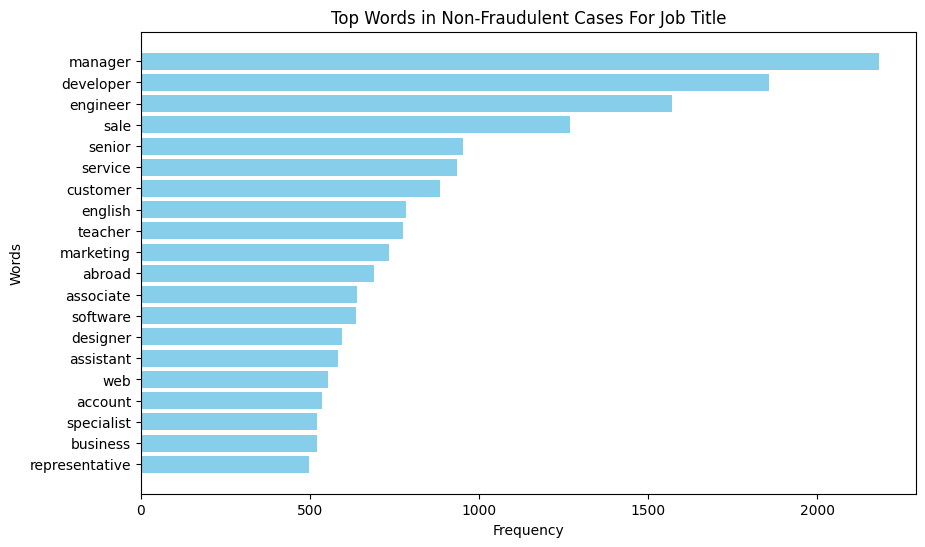

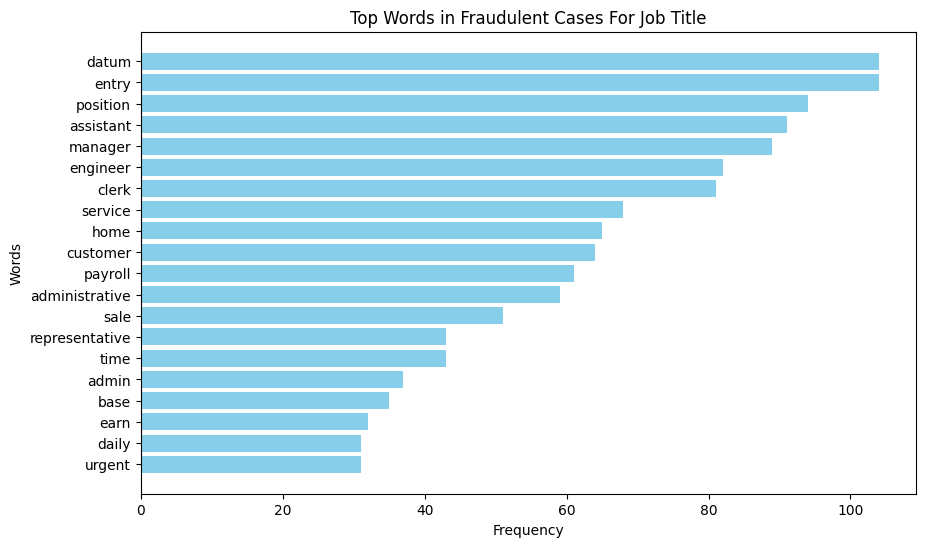

In [180]:
# Get word frequencies for non-fraudulent cases
nonfraud_word_freq = get_word_frequencies(cleaned_text_nonfraud)
# Plot word frequencies for non-fraudulent cases using Matplotlib
plot_word_frequencies(nonfraud_word_freq, 'Top Words in Non-Fraudulent Cases For Job Title')

# Get word frequencies for fraudulent cases
fraud_word_freq = get_word_frequencies(cleaned_text_fraud)
# Plot word frequencies for fraudulent cases using Matplotlib
plot_word_frequencies(fraud_word_freq, 'Top Words in Fraudulent Cases For Job Title')

### Cleaned Company Profile Analysis

In [181]:
#nonfraud text
cleaned_df_nonfraud = cleaned_df[cleaned_df['fraudulent'] == 0]
cleaned_text_nonfraud = ' '.join(cleaned_df_nonfraud['cleaned_company_profile'].dropna())

#fraud text
cleaned_df_fraud = cleaned_df[cleaned_df['fraudulent'] == 1]
cleaned_text_fraud = ' '.join(cleaned_df_fraud['cleaned_company_profile'].dropna())

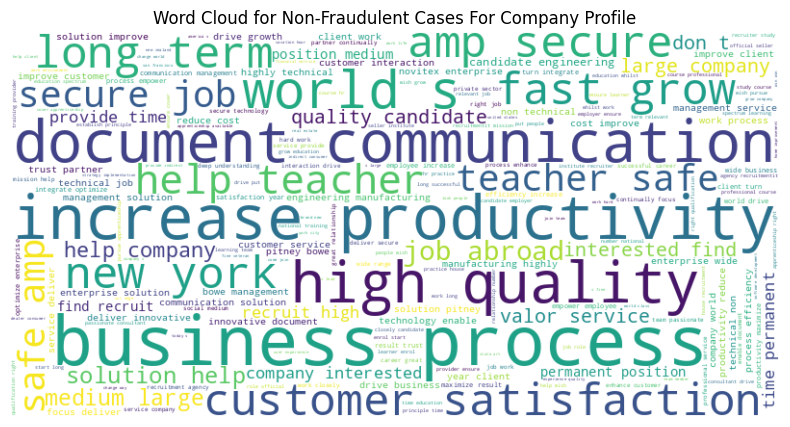

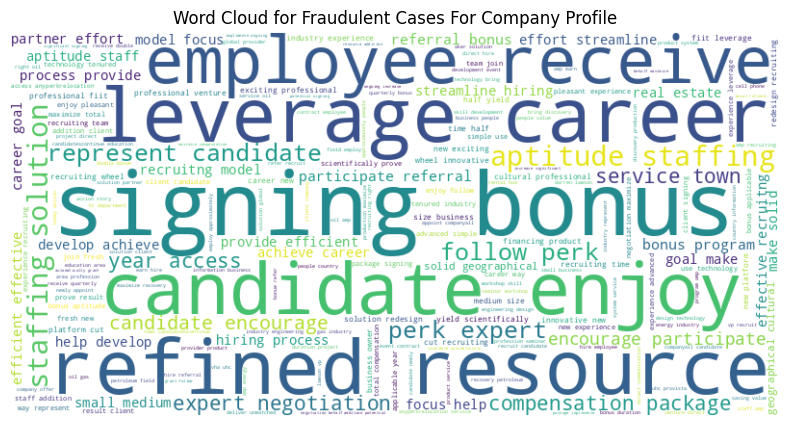

In [182]:
# Generate and display word cloud for fraudulent == 0
generate_word_cloud(cleaned_text_nonfraud, 'Word Cloud for Non-Fraudulent Cases For Company Profile')

# Generate and display word cloud for fraudulent == 1
generate_word_cloud(cleaned_text_fraud, 'Word Cloud for Fraudulent Cases For Company Profile')

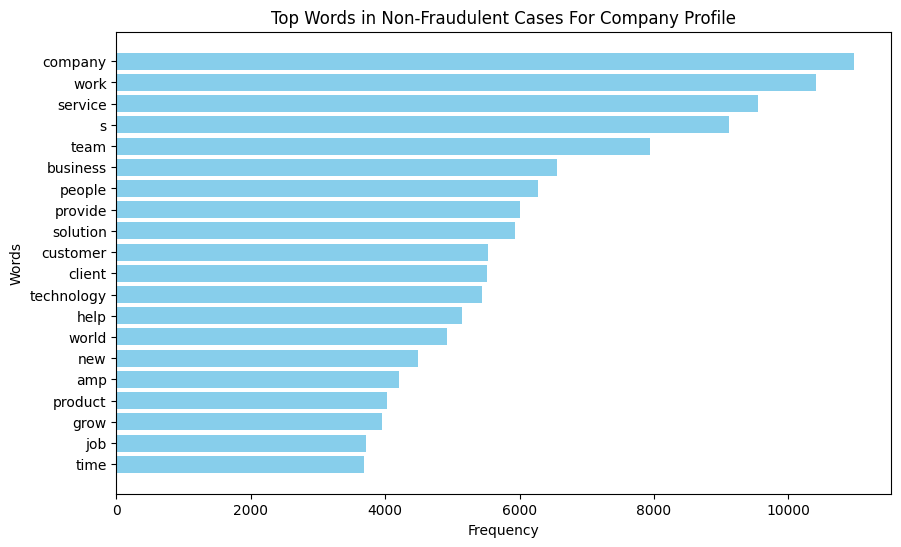

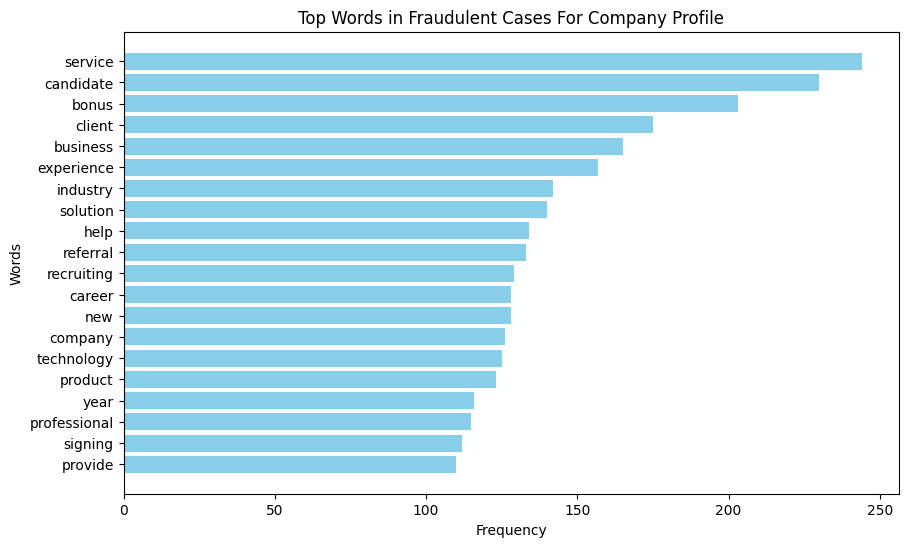

In [183]:
# Get word frequencies for non-fraudulent cases
nonfraud_word_freq = get_word_frequencies(cleaned_text_nonfraud)
# Plot word frequencies for non-fraudulent cases
plot_word_frequencies(nonfraud_word_freq, 'Top Words in Non-Fraudulent Cases For Company Profile')

# Get word frequencies for fraudulent cases
fraud_word_freq = get_word_frequencies(cleaned_text_fraud)
# Plot word frequencies for fraudulent cases
plot_word_frequencies(fraud_word_freq, 'Top Words in Fraudulent Cases For Company Profile')

### Cleaned Description Analysis

In [112]:
#nonfraud text
cleaned_df_nonfraud = cleaned_df[cleaned_df['fraudulent'] == 0]
cleaned_text_nonfraud = ' '.join(cleaned_df_nonfraud['cleaned_description'].dropna())

#fraud text
cleaned_df_fraud = cleaned_df[cleaned_df['fraudulent'] == 1]
cleaned_text_fraud = ' '.join(cleaned_df_fraud['cleaned_description'].dropna())

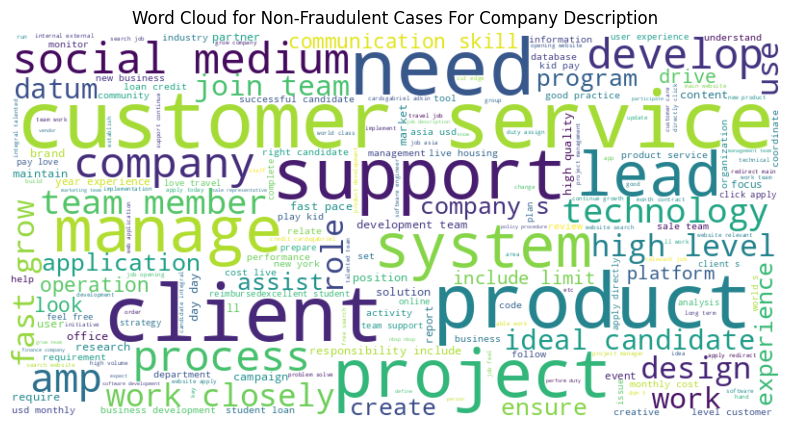

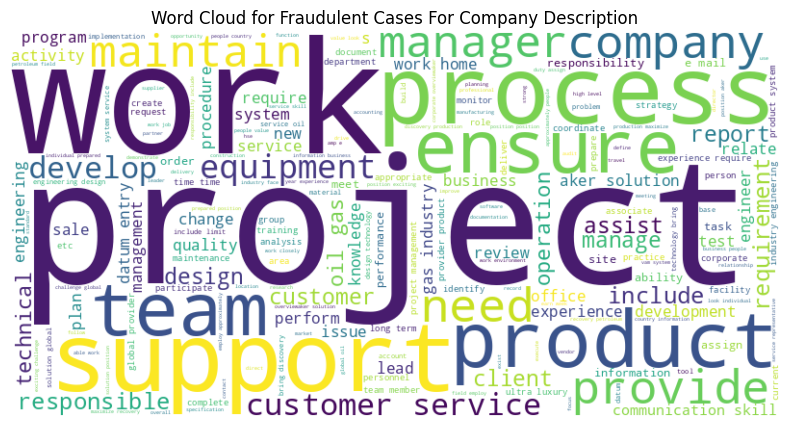

In [113]:
# Generate and display word cloud for fraudulent == 0
generate_word_cloud(cleaned_text_nonfraud, 'Word Cloud for Non-Fraudulent Cases For Company Description')

# Generate and display word cloud for fraudulent == 1
generate_word_cloud(cleaned_text_fraud, 'Word Cloud for Fraudulent Cases For Company Description')

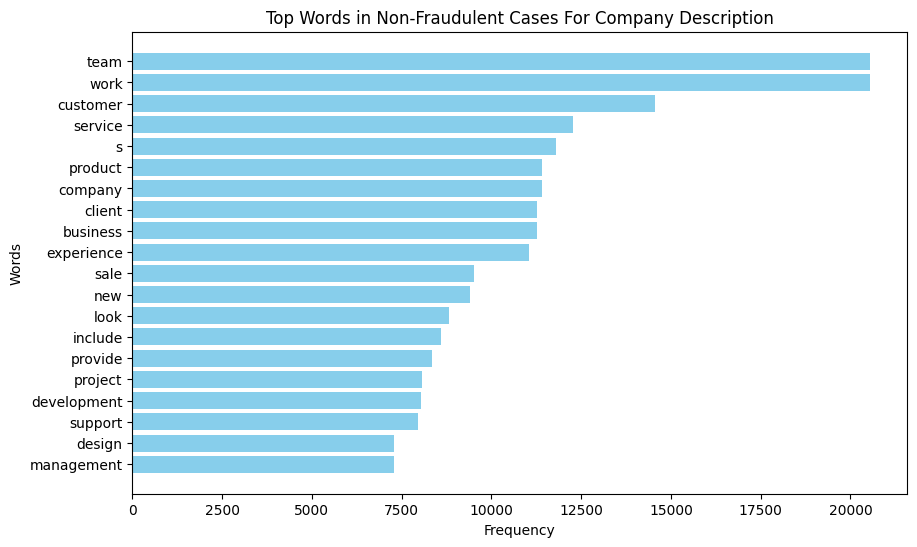

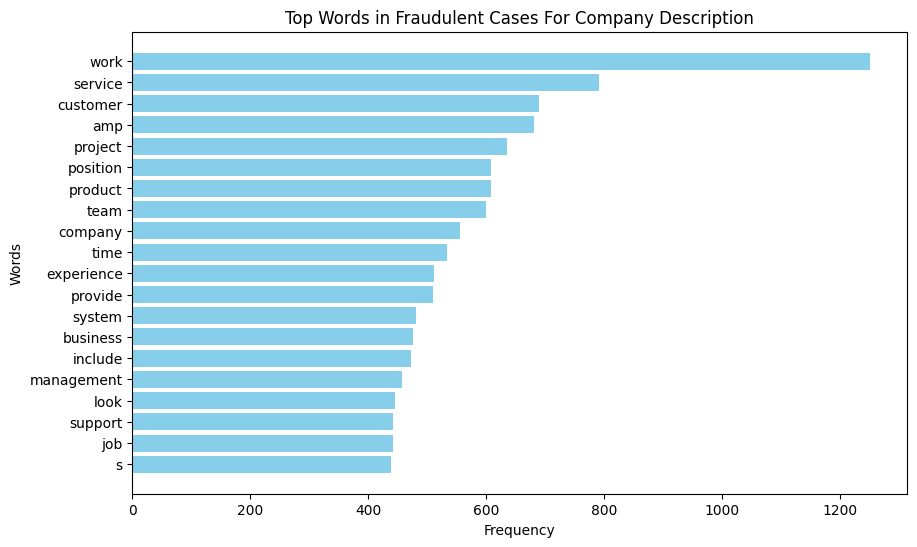

In [114]:
# Get word frequencies for non-fraudulent cases
nonfraud_word_freq = get_word_frequencies(cleaned_text_nonfraud)
# Plot word frequencies for non-fraudulent cases
plot_word_frequencies(nonfraud_word_freq, 'Top Words in Non-Fraudulent Cases For Company Description')

# Get word frequencies for fraudulent cases
fraud_word_freq = get_word_frequencies(cleaned_text_fraud)
# Plot word frequencies for fraudulent cases
plot_word_frequencies(fraud_word_freq, 'Top Words in Fraudulent Cases For Company Description')

# Data Reduction, Transformation and Feature Engineering


For Categorical Values

* **salary_range** and **department** are dropped
* **employment_type** is one-hot-encoded, since it only has 5 unique values and non-ordinal. Null values are also encoded as a separate column
* **required_experience** is label-encoded, since it is ordinal and null values are given the label 0.
* **required_education** is label-encoded, since it is ordinal and null values are given the label 0.
* Only the top 4 values for fraud rate in **industry** are one-hot-encoded, with other values encoded as a separate column to avoid the curse of dimensionality
* Only the top 7 values for fraud rate in **function** are one-hot-encoded, with other values encoded as a separate column to avoid the curse of dimensionality



In [184]:
# Null values
null_counts = cleaned_df.isnull().sum()
print('Null Values: ')
print(null_counts)

# Drop salary range and department column due to them having too many null values (11.3k and 14.8k respectively)
cleaned_df=cleaned_df.drop(columns=['salary_range','department'], errors='ignore')

# Many unique values in industry and function column (131 and 37 respectively). To reduce dimensionality, we will only choose certain industry and function that have higher fraud rate to include in our model. This will be done under feature engineering step later.
unique_industry_count = cleaned_df['industry'].nunique()
print(f"Number of unique values in industry: {unique_industry_count}")

unique_function_count = cleaned_df['function'].nunique()
print(f"Number of unique values in function: {unique_function_count}")

# Fill null values in these columns with "NULL"
cleaned_df[['employment_type']] = cleaned_df[['employment_type']].fillna("NULL")

# One-hot encode the employment_type column since it does not have a clear order
cleaned_df = pd.get_dummies(cleaned_df, columns=['employment_type'], prefix='employment_type')


Null Values: 
title                          0
location                     341
department                 11328
salary_range               14772
company_profile             3282
description                    1
requirements                2649
benefits                    7108
telecommuting                  0
has_company_logo               0
has_questions                  0
employment_type             3428
required_experience         6962
required_education          8009
industry                    4837
function                    6363
fraudulent                     0
cleaned_title                  1
cleaned_company_profile     3311
cleaned_description           10
cleaned_requirements        2694
cleaned_benefits            7162
dtype: int64
Number of unique values in industry: 131
Number of unique values in function: 37


In [185]:
# Label encode the required experience and required education since there is a clear order to it
value_counts_experience = df['required_experience'].value_counts()
value_counts_education = df['required_education'].value_counts()
print(value_counts_experience)
print(value_counts_education)

# Fill null values in required experience with "Not Applicable" for standardisation since one of the unique value is "Not Applicable"
cleaned_df[['required_experience']] = cleaned_df[['required_experience']].fillna("Not Applicable")

# Fill null values in required education with "Unspecified" for standardisation since one of the unique value is "Unspecified"
cleaned_df[['required_education']] = cleaned_df[['required_education']].fillna("Unspecified")

# Custom levels for required experience
custom_experience_levels = ['Not Applicable', 'Internship', 'Entry level', 'Associate', 'Mid-Senior level', 'Director', 'Executive']

# Custom levels for required education
custom_education_levels = [
    "Unspecified", "Some High School Coursework", "High School or equivalent", "Vocational - HS Diploma", "Vocational", "Some College Coursework Completed",
    "Vocational - Degree", "Certification", "Associate Degree" , "Bachelor's Degree", "Professional",
    "Master's Degree", "Doctorate"
]

# Map the custom levels to integers
experience_level_mapping = {level: idx for idx, level in enumerate(custom_experience_levels)}
cleaned_df['required_experience'] = cleaned_df['required_experience'].map(experience_level_mapping)

education_level_mapping = {level: idx for idx, level in enumerate(custom_education_levels)}
cleaned_df['required_education'] = cleaned_df['required_education'].map(education_level_mapping)


required_experience
Mid-Senior level    3768
Entry level         2637
Associate           2267
Not Applicable      1070
Director             383
Internship           372
Executive            140
Name: count, dtype: int64
required_education
Bachelor's Degree                    5099
High School or equivalent            1989
Unspecified                          1369
Master's Degree                       416
Associate Degree                      264
Certification                         165
Some College Coursework Completed     100
Professional                           73
Vocational                             47
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: count, dtype: int64


In [186]:
# Too many unique values in industry and function to one-hot encode so to prevent curse of dimensionality, we will only select certain industry and functions that has higher fraud rates to one-hot encode.

industry_values_to_encode = ['Oil & Energy', 'Accounting', 'Leisure, Travel & Tourism', 'Computer Networking']
function_values_to_encode = ['Administrative', 'Accounting/Auditing', 'Distribution', 'Financial Analyst', 'Other', 'Finance', 'Engineering']

# Apply one-hot encoding only to specified values
df_industry_encoded = pd.get_dummies(cleaned_df['industry'].apply(lambda x: x if x in industry_values_to_encode else 'Other_industry'))

# Apply one-hot encoding only to specified values
df_function_encoded = pd.get_dummies(cleaned_df['function'].apply(lambda x: x if x in function_values_to_encode else 'Other_function'))

# Combine with the original DataFrame
cleaned_df = pd.concat([cleaned_df, df_industry_encoded, df_function_encoded], axis=1)
print(cleaned_df.dtypes)


title                        object
location                     object
company_profile              object
description                  object
requirements                 object
benefits                     object
telecommuting                 int64
has_company_logo              int64
has_questions                 int64
required_experience           int64
required_education            int64
industry                     object
function                     object
fraudulent                    int64
cleaned_title                object
cleaned_company_profile      object
cleaned_description          object
cleaned_requirements         object
cleaned_benefits             object
employment_type_Contract       bool
employment_type_Full-time      bool
employment_type_NULL           bool
employment_type_Other          bool
employment_type_Part-time      bool
employment_type_Temporary      bool
Accounting                     bool
Computer Networking            bool
Leisure, Travel & Tourism   

# Train-Test-Split Processing for Modelling

In [189]:
X = cleaned_df.drop(columns='fraudulent')
y = cleaned_df.fraudulent
print(X.shape)
print(y.shape)

(17599, 37)
(17599,)


In [190]:
from sklearn.model_selection import train_test_split

# First split: 70% for training and 30% for remaining (validation + test)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, random_state=1, test_size=0.3, stratify=y)

# Second split: 50% for validation and 50% for testing from the remaining data
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, random_state=1, test_size=0.5, stratify=y_remaining)

# Print shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (12319, 37)
Validation set shape: (2640, 37)
Test set shape: (2640, 37)


# Modelling with Non-Text Features first

All Object Types were dropped, and will start by modelling all binary and categorical (encoded) features first.

Features included this round:
* **Binary:** 'telecommuting', 'has_company_logo', 'has_questions'
* **Label-encoded:** 'required_experience', 'required_education'
* **Employment type (One-hot encoded)**: 'employment_type_Contract','employment_type_Full-time', 'employment_type_NULL', 'employment_type_Other', 'employment_type_Part-time', 'employment_type_Temporary'
* **Top 5 values for Fraud Rate in Industry (One-hot encoded):** 'Oil & Energy', 'Accounting', 'Leisure, Travel & Tourism', 'Computer Networking' + 'Other_industry'
* **Top 7 values for Fraud Rate in Function (One-hot encoded):** 'Administrative', 'Accounting/Auditing', 'Distribution', 'Financial Analyst', 'Other', 'Finance', 'Engineering' + 'Other_function'


In [191]:
from imblearn.over_sampling import SMOTE

# Drop all columns with 'object' dtype
object_columns = cleaned_df.select_dtypes(include=['object']).columns

X_train2 = X_train.drop(columns=object_columns)
X_val2 = X_val.drop(columns=object_columns)
X_test2 = X_test.drop(columns=object_columns)

#SMOTE Set
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train2, y_train)

In [192]:
X_train2.columns

Index(['telecommuting', 'has_company_logo', 'has_questions',
       'required_experience', 'required_education', 'employment_type_Contract',
       'employment_type_Full-time', 'employment_type_NULL',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary', 'Accounting', 'Computer Networking',
       'Leisure, Travel & Tourism', 'Oil & Energy', 'Other_industry',
       'Accounting/Auditing', 'Administrative', 'Distribution', 'Engineering',
       'Finance', 'Financial Analyst', 'Other', 'Other_function'],
      dtype='object')

## Using Logistic Regression, SVM, MNB, RandomForest, XGB and LightGBM on Non-Text Features (Hyperparameter Tuning)

In [193]:
# Clean feature names for LightGBM
X_train2.columns = X_train2.columns.str.replace(r'[^\w\s]', '_', regex=True)
X_val2.columns = X_val2.columns.str.replace(r'[^\w\s]', '_', regex=True)

X_train_smote.columns = X_train_smote.columns.str.replace(r'[^\w\s]', '_', regex=True)

In [194]:
# Calculate proportions (More class prior) for MNB
class_distribution = y_train.value_counts(normalize=True)
print("\nClass distribution (proportions):")
print(class_distribution)


Class distribution (proportions):
fraudulent
0    0.951376
1    0.048624
Name: proportion, dtype: float64


In [195]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000),
    "SVM": SVC(kernel="rbf", class_weight="balanced", random_state=42, probability=True),
    "Multinomial Naive Bayes": MultinomialNB(class_prior=[0.95, 0.05]),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
    ),
    "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced")
}


def evaluate_model(model_name, model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)

    # Predictions and probabilities
    y_val_pred = model.predict(X_val)
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]

    # Metrics
    roc_auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Model: {model_name}")
    print("Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print(f"ROC-AUC Score: {roc_auc:.3f}\n")
    return roc_auc

results = {}
for model_name, model in models.items():
    roc_auc = evaluate_model(model_name, model, X_train2, y_train, X_val2, y_val)
    results[model_name] = roc_auc

# Summary of results
print("\nSummary of ROC-AUC Scores: (Using Hyperparameters)")
for model_name, score in results.items():
    print(f"{model_name}: {score:.3f}")


Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      2512
           1       0.16      0.78      0.26       128

    accuracy                           0.79      2640
   macro avg       0.57      0.78      0.57      2640
weighted avg       0.95      0.79      0.85      2640

ROC-AUC Score: 0.846

Model: SVM
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      2512
           1       0.18      0.85      0.29       128

    accuracy                           0.80      2640
   macro avg       0.58      0.83      0.59      2640
weighted avg       0.95      0.80      0.86      2640

ROC-AUC Score: 0.894

Model: Multinomial Naive Bayes
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2512
           1       0.78      0.14      0.24       128



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:25:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2512
           1       0.22      0.83      0.34       128

    accuracy                           0.85      2640
   macro avg       0.60      0.84      0.63      2640
weighted avg       0.95      0.85      0.89      2640

ROC-AUC Score: 0.919

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 599, number of negative: 11720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 12319, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training 

## Using Logistic Regression, SVM, MNB, RandomForest, XGB and LightGBM on Non-Text Features (SMOTE)


In [196]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(kernel="rbf", random_state=42, probability=True),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    ),
    "LightGBM": LGBMClassifier(random_state=42)
}


def evaluate_model(model_name, model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)

    # Predictions and probabilities
    y_val_pred = model.predict(X_val)
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]

    # Metrics
    roc_auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Model: {model_name}")
    print("Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print(f"ROC-AUC Score: {roc_auc:.3f}\n")
    return roc_auc

results = {}
for model_name, model in models.items():
    roc_auc = evaluate_model(model_name, model, X_train_smote, y_train_smote, X_val2, y_val)
    results[model_name] = roc_auc

# Summary of results
print("\nSummary of ROC-AUC Scores: (With SMOTE)")
for model_name, score in results.items():
    print(f"{model_name}: {score:.3f}")

Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      2512
           1       0.17      0.78      0.28       128

    accuracy                           0.80      2640
   macro avg       0.58      0.79      0.58      2640
weighted avg       0.95      0.80      0.85      2640

ROC-AUC Score: 0.848

Model: SVM
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      2512
           1       0.19      0.84      0.31       128

    accuracy                           0.82      2640
   macro avg       0.59      0.83      0.61      2640
weighted avg       0.95      0.82      0.87      2640

ROC-AUC Score: 0.896

Model: Multinomial Naive Bayes
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      2512
           1       0.12      0.79      0.22       128



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:27:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      2512
           1       0.24      0.80      0.37       128

    accuracy                           0.87      2640
   macro avg       0.61      0.84      0.65      2640
weighted avg       0.95      0.87      0.90      2640

ROC-AUC Score: 0.918

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11720, number of negative: 11720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 23440, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model: LightGBM
Classification R

LightGBM works best. However, all the models perform quite poorly on precision on the minority class.

# Modelling Textual Columns

In [197]:
cleaned_df.dtypes

title                        object
location                     object
company_profile              object
description                  object
requirements                 object
benefits                     object
telecommuting                 int64
has_company_logo              int64
has_questions                 int64
required_experience           int64
required_education            int64
industry                     object
function                     object
fraudulent                    int64
cleaned_title                object
cleaned_company_profile      object
cleaned_description          object
cleaned_requirements         object
cleaned_benefits             object
employment_type_Contract       bool
employment_type_Full-time      bool
employment_type_NULL           bool
employment_type_Other          bool
employment_type_Part-time      bool
employment_type_Temporary      bool
Accounting                     bool
Computer Networking            bool
Leisure, Travel & Tourism      bool
Oil & Energy                   bool
Other_industry                 bool
Accounting/Auditing            bool
Administrative                 bool
Distribution                   bool
Engineering                    bool
Finance                        bool
Financial Analyst              bool
Other                          bool
Other_function                 bool
dtype: object

In [198]:
#Retain only textual columns and concatenating
cleaned_textual_columns=['cleaned_title', 'cleaned_company_profile', 'cleaned_description', 'cleaned_requirements', 'cleaned_benefits']

cleaned_df['all_texts'] = cleaned_df[cleaned_textual_columns].fillna('').apply(lambda x: ' '.join(x), axis=1)
X_train['all_texts'] = X_train[cleaned_textual_columns].fillna('').apply(lambda x: ' '.join(x), axis=1)
X_train['all_texts'] = X_train[cleaned_textual_columns].fillna('').apply(lambda x: ' '.join(x), axis=1)
X_val['all_texts'] = X_val[cleaned_textual_columns].fillna('').apply(lambda x: ' '.join(x), axis=1)
X_test['all_texts'] = X_test[cleaned_textual_columns].fillna('').apply(lambda x: ' '.join(x), axis=1)

X_train3 = X_train['all_texts']
X_val3 = X_val['all_texts']
X_test3 = X_test['all_texts']

## BOW Model using Logistic Regression, SVM, MNB, RandomForest, XGB and LightGBM

In [200]:
#Takes a long time to run!
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, roc_auc_score

# Custom transformer to cast sparse matrix to float
def to_float32(X):
    return X.astype('float32')

cast_to_float32 = FunctionTransformer(to_float32)

# Dictionary of models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'Multinomial Naive Bayes': MultinomialNB(class_prior=[0.95, 0.05]),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=sum(y_train == 0) / sum(y_train == 1)),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42)
}

vectorizer = CountVectorizer(stop_words='english', max_features=10000)
results = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('to_float32', cast_to_float32),  # Ensure data is cast to float32
        ('classifier', model)
    ])

    pipeline.fit(X_train3, y_train)

    # Make predictions
    y_pred_prob = pipeline.predict_proba(X_val3)[:, 1]
    y_pred = pipeline.predict(X_val3)

    # Evaluate performance
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    results[model_name] = {
        'roc_auc_score': roc_auc,
        'classification_report': classification_report(y_val, y_pred, output_dict=True)
    }

    # Print results
    print(f"ROC-AUC Score for {model_name}: {roc_auc}")
    print(classification_report(y_val, y_pred))

# Print summary
print("\nSummary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: ROC-AUC = {metrics['roc_auc_score']:.4f}")


ROC-AUC Score for Logistic Regression: 0.9584494426751592
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2512
           1       0.70      0.84      0.76       128

    accuracy                           0.97      2640
   macro avg       0.85      0.91      0.88      2640
weighted avg       0.98      0.97      0.98      2640

ROC-AUC Score for SVM: 0.9643741291799364
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2512
           1       0.58      0.82      0.68       128

    accuracy                           0.96      2640
   macro avg       0.78      0.89      0.83      2640
weighted avg       0.97      0.96      0.97      2640

ROC-AUC Score for Multinomial Naive Bayes: 0.9476683792794586
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2512
           1       0.37      0.86      0.52       128

    accuracy        

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:41:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC-AUC Score for XGBoost: 0.9563221536624203
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2512
           1       0.82      0.77      0.79       128

    accuracy                           0.98      2640
   macro avg       0.91      0.88      0.89      2640
weighted avg       0.98      0.98      0.98      2640

[LightGBM] [Info] Number of positive: 599, number of negative: 11720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.532500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26328
[LightGBM] [Info] Number of data points in the train set: 12319, number of used features: 6092
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC-AUC Score for LightGBM: 0.9724914162022292
              precisi

## TFIDF Model Logistic Regression, SVM, MNB, RandomForest, XGB and LightGBM

In [201]:
#Takes a long long long time to run, esp svm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, roc_auc_score

# Custom transformer to cast sparse matrix to float
def to_float32(X):
    return X.astype('float32')

cast_to_float32 = FunctionTransformer(to_float32)

# Dictionary of models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'Multinomial Naive Bayes': MultinomialNB(class_prior=[0.95, 0.05]),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=sum(y_train == 0) / sum(y_train == 1)),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42)
}

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
results = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('to_float32', cast_to_float32),  # Ensure data is cast to float32
        ('classifier', model)
    ])

    pipeline.fit(X_train3, y_train)

    # Make predictions
    y_pred_prob = pipeline.predict_proba(X_val3)[:, 1]
    y_pred = pipeline.predict(X_val3)

    # Evaluate performance
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    results[model_name] = {
        'roc_auc_score': roc_auc,
        'classification_report': classification_report(y_val, y_pred, output_dict=True)
    }

    # Print results
    print(f"ROC-AUC Score for {model_name}: {roc_auc}")
    print(classification_report(y_val, y_pred))

# Print summary
print("\nSummary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: ROC-AUC = {metrics['roc_auc_score']:.4f}")


ROC-AUC Score for Logistic Regression: 0.9664392167595541
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2512
           1       0.62      0.86      0.72       128

    accuracy                           0.97      2640
   macro avg       0.81      0.92      0.85      2640
weighted avg       0.97      0.97      0.97      2640

ROC-AUC Score for SVM: 0.9665822800557325
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2512
           1       0.94      0.74      0.83       128

    accuracy                           0.99      2640
   macro avg       0.96      0.87      0.91      2640
weighted avg       0.98      0.99      0.98      2640

ROC-AUC Score for Multinomial Naive Bayes: 0.9018927896098726
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2512
           1       0.70      0.15      0.25       128

    accuracy        

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:49:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC-AUC Score for XGBoost: 0.9663428045382166
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2512
           1       0.85      0.77      0.81       128

    accuracy                           0.98      2640
   macro avg       0.92      0.88      0.90      2640
weighted avg       0.98      0.98      0.98      2640

[LightGBM] [Info] Number of positive: 599, number of negative: 11720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.725797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371280
[LightGBM] [Info] Number of data points in the train set: 12319, number of used features: 6092
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC-AUC Score for LightGBM: 0.9714464321257963
              precis

The CountVectorizer (BOW Model) seems to produce better results in predicting fraudulent jobs.

# Post Insights: Words that highly predict Fraud
These are common mispellings/words that occur in fraudulent postings

In [202]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Fit CountVectorizer on all texts
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X_all_texts = cleaned_df['all_texts']

X_dtm = vectorizer.fit_transform(X_all_texts)
word_counts = X_dtm.toarray()
words = np.array(vectorizer.get_feature_names_out())

X_fraud = X_train.loc[y_train == 1, 'all_texts']
X_non_fraud = X_train.loc[y_train == 0, 'all_texts']

X_fraud_dtm = vectorizer.transform(X_fraud)
X_non_fraud_dtm = vectorizer.transform(X_non_fraud)

# Sum the word counts for each case
fraud_word_counts = X_fraud_dtm.sum(axis=0).A1
non_fraud_word_counts = X_non_fraud_dtm.sum(axis=0).A1

In [203]:
fraud_to_non_fraud_ratio = fraud_word_counts / (non_fraud_word_counts+0.1)

top_idx = np.argsort(fraud_to_non_fraud_ratio)[::-1]

top_words = words[top_idx[:10]]
top_ratios = fraud_to_non_fraud_ratio[top_idx[:10]]

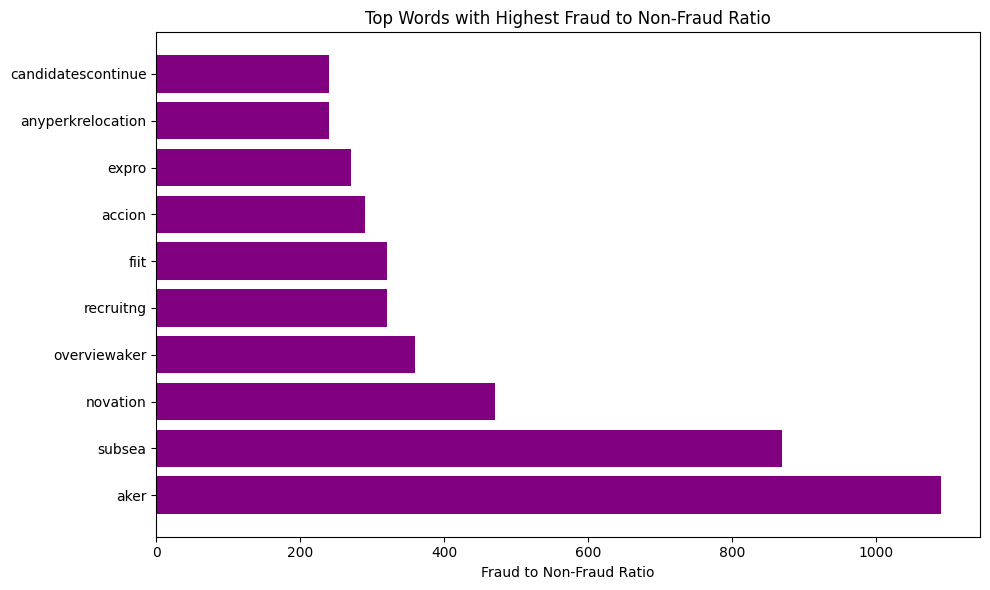

aker: 1090.0
subsea: 870.0
novation: 470.0
overviewaker: 360.0
recruitng: 320.0
fiit: 320.0
accion: 290.0
expro: 270.0
anyperkrelocation: 240.0
candidatescontinue: 240.0


In [204]:
plt.figure(figsize=(10, 6))
plt.barh(top_words, top_ratios, color='purple')
plt.title("Top Words with Highest Fraud to Non-Fraud Ratio")
plt.xlabel("Fraud to Non-Fraud Ratio")
plt.tight_layout()
plt.show()

# Print the top words and their ratios
for word, ratio in zip(top_words, top_ratios):
    print(f"{word}: {ratio}")

In [205]:
def contains_word(text, word):
    return word.lower() in text.lower() if isinstance(text, str) else False  # Handle non-string values

columns_to_check = ['description', 'requirements', 'benefits', 'title', 'company_profile']

cleaned_df['concatenated_text'] = cleaned_df[columns_to_check].apply(lambda row: ' '.join(row.astype(str)), axis=1)

instances_with_word = cleaned_df[cleaned_df['concatenated_text'].apply(lambda text: contains_word(text, ' recruitng '))]


In [206]:
pd.set_option('display.max_colwidth', None)
instances_with_word[['title', 'location', 'company_profile', 'fraudulent']]

title  \
173                 Technician Instrument & Controls    
606                              Director of Strategy   
628                        UST Testing Technician II    
816                 Technician Instrument & Controls    
825                       Project Controls Technician   
1204              Health + Environmental Professional   
3269                      Process Engineer Mechanical   
3933                      Project Manager: Mechanical   
3947                        Project Manager: Engineer   
5472                   Research Engineer Data Science   
5504                 Director of Technical Operations   
5567                          Process Safety Engineer   
5838                       UST Testing Technician III   
7047                                      QA Engineer   
7344               Senior System Engineering Manager    
7748                                       Accountant   
8249                      Senior System Test Engineer   
8288               Senior Engineering Product Manager   
8309                              Software Architect    
8477           Senior Software Engineer QA Automation   
8482                             Operator Mechanic 1    
8488                      UTC Lead Testing Technician   
9088                        Mobile Developer-Back End   
9111           Director of Engineering | Applications   
9115                       Mobile Developer-Back End    
9117                    Business Operations Associate   
9263                                 IC&E Technician    
9823                     Health + Safety Professional   
9831                                   Plant Operator   
9833                 Director of Technical Operations   
9834                   Director of Product Management   
9841                    Client Services Manager - SM1   
9842                 Client Services Manager NY, NY 1   
9845                              Senior QA Engineer    
9847   Software Engineer | Forecasting & Optimization   
9878                                  IC&E Technician   
9971    Director of Engineering HMA Security Products   
10230                         Communications Manager    
10396                Director of Software Engineering   
11565                    Information Security Manager   
11569                       Technical Program Manager   
11587                                    SEO Analysis   
11739                          UST Testing Technician   

                                 location  \
173                                    US   
606                     US, CA, San Mateo   
628                   US, CA, Bakersfield   
816                    US, TX, Deweyville   
825                   US, CA, Bakersfield   
1204                  US, CA, Bakersfield   
3269                  US, CA, Bakersfield   
3933                  US, CA, Bakersfield   
3947                  US, CA, Bakersfield   
5472                    US, CA, San Mateo   
5504                           US, NY, NY   
5567                  US, CA, Bakersfield   
5838              US, CA, Bakersfield, CA   
7047                     US, CA, San Jose   
7344                     US, CA, San Jose   
7748                    US, CA, San Mateo   
8249                     US, CA, San Jose   
8288                     US, CA, San Jose   
8309                       US, , San Jose   
8477                    US, CA, San Mateo   
8482             US, CA, City of Industry   
8488                  US, CA, Bakersfield   
9088                      US, WA, Seattle   
9111                US, CA, San Francisco   
9115                US, CA, San Francisco   
9117                US, KS, Overland Park   
9263   US, CA, Bakersfield, CA / Mt. Poso   
9823                  US, CA, Bakersfield   
9831                  US, CA, Bakersfield   
9833                           US, NY, NY   
9834                   US, CA, San Mateo    
9841                    US, CA, San Mateo   
9842                           US, NY, NY   
9845     

# Combined Modelling


In [207]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Prepare text features
X_train2 = X_train2.astype('float64')
X_val2 = X_val2.astype('float64')
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X_text = vectorizer.fit_transform(X_train3)

# Non-text features (already label-encoded or one-hot-encoded)
X_train_non_text_sparse = csr_matrix(X_train2)  # Ensure sparse matrix format

# Combine text and non-text features
X_combined = hstack([X_text, X_train_non_text_sparse])

X_val_text = vectorizer.transform(X_val3)
X_val_non_text_sparse = csr_matrix(X_val2)
X_val_combined = hstack([X_val_text, X_val_non_text_sparse])

#Use of LGBM
model2 = LGBMClassifier(class_weight='balanced', random_state=42)
model2.fit(X_combined, y_train)

y_pred_prob2 = model2.predict_proba(X_val_combined)[:, 1]
y_pred2 = model2.predict(X_val_combined)

print("ROC-AUC Score LightGBM:", roc_auc_score(y_val, y_pred_prob2))
print("Classification Report:")
print(classification_report(y_val, y_pred2))

[LightGBM] [Info] Number of positive: 599, number of negative: 11720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.299765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26388
[LightGBM] [Info] Number of data points in the train set: 12319, number of used features: 6114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC-AUC Score LightGBM: 0.9803225766321655
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2512
           1       0.85      0.82      0.83       128

    accuracy                           0.98      2640
   macro avg       0.92      0.91      0.91      2640
weighted avg       0.98      0.98      0.98      2640



Text(0.5, 1.0, 'Confusion Matrix for Fraudulent Job Postings')

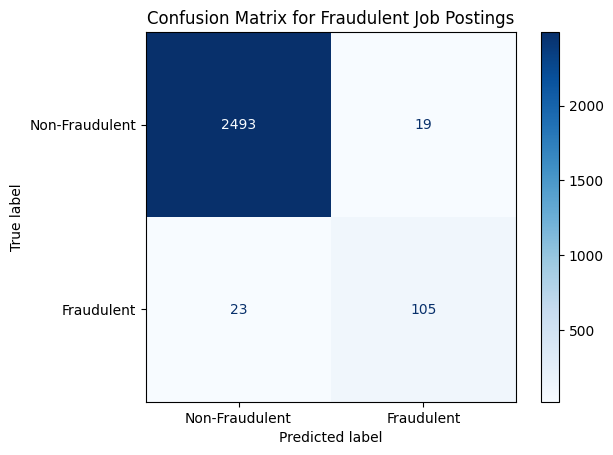

In [208]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred2)

# Custom class labels
class_labels = ["Non-Fraudulent", "Fraudulent"]

# Display the confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")

# Add a title for better context
disp.ax_.set_title("Confusion Matrix for Fraudulent Job Postings")

# Final Evaluation on Test


In [210]:
X_test2 = X_test2.astype('float64')

X_text_test = vectorizer.transform(X_test3)
X_train_non_text_sparse_test = csr_matrix(X_test2)

X_combined_test = hstack([X_text_test, X_train_non_text_sparse_test])

y_pred_prob_test = model2.predict_proba(X_combined_test)[:, 1]
y_pred_test = model2.predict(X_combined_test)
print("ROC-AUC Score LightGBM:", roc_auc_score(y_test, y_pred_prob_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

ROC-AUC Score LightGBM: 0.9903926598933686
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2511
           1       0.79      0.86      0.82       129

    accuracy                           0.98      2640
   macro avg       0.89      0.92      0.91      2640
weighted avg       0.98      0.98      0.98      2640



Text(0.5, 1.0, 'Confusion Matrix for Fraudulent Job Postings')

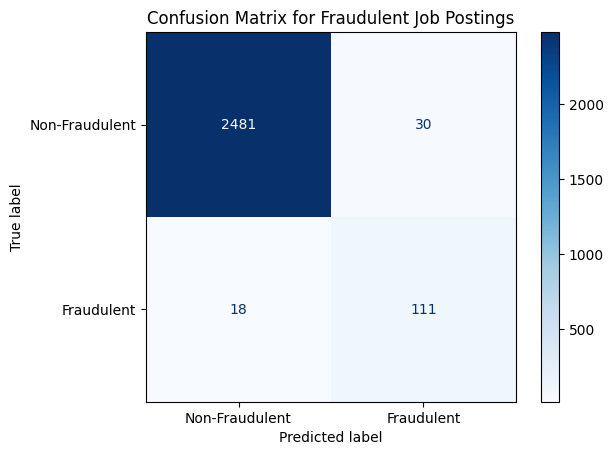

In [211]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)

# Custom class labels
class_labels = ["Non-Fraudulent", "Fraudulent"]

# Display the confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_labels)
disp.plot(cmap="Blues")

# Add a title for better context
disp.ax_.set_title("Confusion Matrix for Fraudulent Job Postings")